### Structural Geology 
http://www.geosci.usyd.edu.au/users/prey/Patrice_Intro_to_SG.pdf

## map2loop: Hamersely maps

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into a mdelling engine to make a 3D model 


## Choose map area
1. Run cell below
2. Select map area from drop down menu   
3. Click in next cell and run next cells to define modelling engine run to end using menu:  
   *Cell->Run all below*


In [4]:
import ipywidgets as widgets
import os

import sys
sys.path.append('../../map2loop')

# load last saved map area and mdoe engine (if they exist)
if(os.path.isfile('../last_choices.txt')):
    f=open('../last_choices.txt','r')
    contents =f.readlines()
    f.close()
    default_map=contents[0].replace("\n","")
    default_engine=contents[1].replace("\n","")
else:
    default_map='test_data3'
    default_engine='loopstructural'

map_choice=widgets.Dropdown(
    options=['test_data3','Turner_Syncline'],
    value=default_map,
    description='Map area:',
    disabled=False,
)
display(map_choice)

Dropdown(description='Map area:', index=1, options=('test_data3', 'Turner_Syncline'), value='Turner_Syncline')

In [4]:
test_data_name=map_choice.value
print(test_data_name)


test_data3


117.38194472 118.45173019 -21.6250247 -20.63473878
dtm geotif saved as c:\users\rscott\Downloads\pilbaradtm.tif


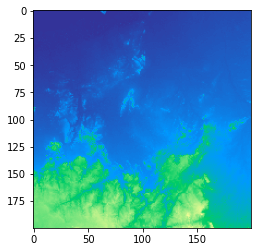

In [9]:
minlong, minlat, maxlong, maxlat = [117.3819447200000070,-21.6250247000000009, 118.4517301900000064,-20.6347387799999993]
print(minlong,maxlong,minlat,maxlat)
pendockfile = r'c:\users\rscott\Downloads\pilbaradtm.tif'

import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
from map2loop import m2l_map_checker
import time
import shutil
%matplotlib inline
t0 = time.time()

m2l_utils.get_dtm(pendockfile, minlong,maxlong,minlat,maxlat)
geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)

dtm = rasterio.open(pendockfile)
pyplot.imshow(dtm.read(1), cmap='terrain',vmin=0,vmax=1000)
pyplot.show()



In [11]:

def get_dtm_richard(path_out, minlong,maxlong,minlat,maxlat):

    import geopandas as gpd
    import pandas as pd
    from shapely.geometry.polygon import Polygon
    from shapely.geometry.multipolygon import MultiPolygon
    from shapely.geometry import Point
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    from rasterio.transform import from_origin
    from rasterio import features
    import re    #typo? check
    from urllib.request import urlopen
    from IPython.display import Image
    from math import sin, cos, atan, atan2, asin, radians, degrees, sqrt, pow, acos, fmod, fabs, isnan
    from owslib.wcs import WebCoverageService
    from osgeo import gdal

    bbox=(minlong,minlat,maxlong,maxlat)

    url="http://services.ga.gov.au/gis/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?"
    wcs = WebCoverageService(url,version='1.0.0')

    cvg=wcs.getCoverage(identifier='1',  bbox=bbox, format='GeoTIFF', crs=4326, width=11909, height=11024)

    f = open(path_out, 'wb')
    bytes_written = f.write(cvg.read())
    f.close()
    print("dtm geotif saved as",path_out)
    
path_out2 = r'C:\Users\rscott\Downloads\pilbaradtmbig.tif'    

get_dtm_richard(path_out2, minlong,maxlong,minlat,maxlat)

ReadTimeout: HTTPConnectionPool(host='gaservices.ga.gov.au', port=80): Read timed out. (read timeout=30)

## Choose model engine
1. Run cell below
2. Select modelling engine from drop down menu   
3. Click in next cell and run to end using menu: *Cell->Run all below* 

In [5]:
engine_choice=widgets.Dropdown(
    options=['geomodeller', 'gempy','loopstructural','noddy','null'],
    value=default_engine,
    description='Modeller:',
    disabled=False,
)
display(engine_choice)

Dropdown(description='Modeller:', index=1, options=('geomodeller', 'gempy', 'loopstructural', 'noddy', 'null')…

In [6]:
workflow={'model_engine':engine_choice.value} 
print(workflow['model_engine'])
# save last map and engine choices
f=open('../last_choices.txt','w') 
ostr=str(map_choice.value)+'\n'+str(engine_choice.value)+'\n'
f.write(ostr)
f.close()

gempy


In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
from map2loop import m2l_map_checker
import time
import shutil
%matplotlib inline
t0 = time.time()


In [8]:
faults = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\map2LoopFaultsGA.shp')
print("faults")
lithology = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\map2LoopLithologyGA.shp')
print("lithology")
minocc = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\map2LoopMinOccGA.shp')
print("minocc")
structures = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\StructuresPoint.shp')
print("structures")

faults
lithology
minocc
structures


In [9]:
structuresRichard = structures.copy()
structuresRichard[['Declination','Azimuth']] = structures.observedva.str.split('/',expand=True) 

In [10]:
import urllib.request
from tqdm import tqdm as tqdm

#print(lithology['descr'].value_counts().size)
#print(lithology['descr'].value_counts())
print(lithology['yngage_uri'].unique().size)
yngage = lithology['yngage_uri'].unique().tolist()
agehtml = []
#yngage[1]

for age in tqdm(yngage):
    try:
        uf = urllib.request.urlopen(age)
        html = uf.read()
        agehtml.append(html)
    except Exception as urlfail:
        print(urlfail)
        print(age)
        agehtml.append("Fail_" + age)

  0%|                                                                                          | 0/132 [00:00<?, ?it/s]

132


 42%|██████████████████████████████████▎                                              | 56/132 [00:19<00:21,  3.51it/s]

HTTP Error 404: Not Found
http://resource.geosciml.org/classifier/ics/ischart/CambrianStage7


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:48<00:00,  2.70it/s]

HTTP Error 404: Not Found
http://resource.geosciml.org/classifier/ics/ischart/CambrianStage9


In [11]:
#!pip install lxml
from bs4 import BeautifulSoup
bound_age_yng = []
bound_age_old = []
for index, html in tqdm(enumerate(agehtml)):
    soup = BeautifulSoup(html, "html.parser")
    #res = soup.findAll({"class":"comment"})
    #print(soup.title)
    gdp_table = soup.find("tr", attrs={"class": "comment"})
    #gdp_table = soup.find("td", attrs={"class": "value"})
    headings = []
    #print(len(gdp_table))
    #print(yngage[index])
    #if gdp_table and len(gdp_table) > 1:
    if gdp_table:
        count = 0
        for td in gdp_table.find_all("td", attrs={"class": "value"}):
            count = count + 1
            #print(count)
            #print(td.text)
        #print(gdp_table)
            if "older bound" in td.text and count > 1:
                #print(td.text.strip())
                tdstr = td.text.replace("older bound ", "")
                rest = tdstr.split(" ", 1)[0]
                rest = rest.replace("-","")
                bound_age_old.append(rest)
            if "younger bound" in td.text and count > 1:
                tdstr = td.text.replace("younger bound ", "")
                rest = tdstr.split(" ", 1)[0]
                rest = rest.replace("-","")
                #print(td.text.strip())
                bound_age_yng.append(rest)
    else:
        bound_age_old.append("Fail_" + yngage[index])     
        bound_age_yng.append("Fail_" + yngage[index])     
        #print(res)

#for old in bound_age_old:
    #print(old)
print(len(bound_age_yng))    
#for old in bound_age_yng:
    #print(old)

numeric_yng = {}    
numeric_old = {}
for index, age in enumerate(yngage):
    numeric_yng[age] = bound_age_yng[index]
    numeric_old[age] = bound_age_old[index]
    
print(numeric_yng)    
#!pip install bs4
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/CambrianStage2'] = 529
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/Terreneuvian'] = 541
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/Thanetian'] = 59.2

#numeric_yng['Fail_http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 514
#numeric_old['http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 521
numeric_yng['http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 514
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 521

#Fail_http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3



132it [00:03, 41.66it/s]

132
{'http://resource.geosciml.org/classifier/ics/ischart/Cryogenian': '635', 'http://resource.geosciml.org/classifier/ics/ischart/Quaternary': '0.0', 'http://resource.geosciml.org/classifier/ics/ischart/Holocene': '0.0', 'http://resource.geosciml.org/classifier/ics/ischart/Paleoproterozoic': '1600', 'http://resource.geosciml.org/classifier/ics/ischart/LowerCretaceous': '100.5', 'http://resource.geosciml.org/classifier/ics/ischart/Neoproterozoic': '541.0', 'http://resource.geosciml.org/classifier/ics/ischart/Cenozoic': '0.0', 'http://resource.geosciml.org/classifier/ics/ischart/Cisuralian': '272.95', 'http://resource.geosciml.org/classifier/ics/ischart/Statherian': '1600', 'http://resource.geosciml.org/classifier/ics/ischart/UpperOrdovician': '443.8', 'http://resource.geosciml.org/classifier/ics/ischart/Cretaceous': '66.0', 'http://resource.geosciml.org/classifier/ics/ischart/Archean': '2500', 'http://resource.geosciml.org/classifier/ics/ischart/Lopingian': '251.902', 'http://resource.

In [13]:
xmin = 130.8333
ymin = -13.25
xmax = 131.25
ymax = -12.75

def set_value(row_number, assigned_value): 
    #print(row_number)
    return assigned_value[row_number]         

def aoi_box(dfBroad, xmin, xmax, ymin, ymax):
    dfAoi = dfBroad.cx[xmin:xmax, ymin:ymax]
    return dfAoi

shape_path = r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles' + "\\"

with rasterio.open(r'C:\users\rscott\Downloads\Spectral\test1.tif') as CURNAMONA:
    print(CURNAMONA.meta)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6291, 'height': 7626, 'count': 7, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, 139.30579352719275,
       0.0, -0.00026949458523585647, -29.97561322119908)}


In [14]:
print (CURNAMONA.bounds    )
xminC, yminC, xmaxC, ymaxC = CURNAMONA.bounds
print(xminC)

lithology_Curnamona = aoi_box(lithology, xminC, xmaxC, yminC, ymaxC)
faults_Curnamona = aoi_box(faults, xminC, xmaxC, yminC, ymaxC)
structures_Curnamona = aoi_box(structuresRichard, xminC, xmaxC, yminC, ymaxC)
minocc_Curnamona = aoi_box(minocc, xminC, xmaxC, yminC, ymaxC)

lithology_Curnamona_UTM = lithology_Curnamona.to_crs(epsg=28354)
faults_Curnamona_UTM = faults_Curnamona.to_crs(epsg=28354)
structures_Curnamona_UTM = structures_Curnamona.to_crs(epsg=28354)
minocc_Curnamona_UTM = minocc_Curnamona.to_crs(epsg=28354)

lithology_Curnamona_UTM['yngage'] = lithology_Curnamona_UTM['yngage_uri'].apply(set_value, args =(numeric_yng, )) 
lithology_Curnamona_UTM['oldage'] = lithology_Curnamona_UTM['oldage_uri'].apply(set_value, args =(numeric_old, )) 

print(lithology_Curnamona_UTM['yngage'].unique())

BoundingBox(left=139.30579352719275, bottom=-32.030778928207724, right=141.0011839629115, top=-29.97561322119908)
139.30579352719275
['509' '635' '0.0' '1000' '1600' '1400' '5.333' '0.0117' '541.0' 514
 '298.9' '433.4' '66.0' '37.8']


In [15]:
print(minocc_Curnamona_UTM.shape, minocc.shape, xminC)

(269, 24) (119468, 24) 139.30579352719275


In [16]:
lithology_Curnamona_UTM.to_file(shape_path + 'lithology_Curnamona_UTM.shp')
faults_Curnamona_UTM.to_file(shape_path + 'faults_Curnamona_UTM.shp')
if structures_Curnamona_UTM.shape[0] > 0:
    structures_Curnamona_UTM.to_file(shape_path + 'structures_Curnamona_UTM.shp')
if minocc_Curnamona_UTM.shape[0] > 0:    
    minocc_Curnamona_UTM.to_file(shape_path + 'minocc_Curnamona_UTM.shp')
    
print(lithology_Curnamona_UTM.total_bounds    )

[ 261137.8498951  5918968.94714117 1538726.54120686 7674308.52382104]


## Load config file

In [17]:
test_data_path='../'+test_data_name+'/'
test_data_path = shape_path

os.chdir(test_data_path)
%run -i "m2l_config_richard_GA.py"

#%run -i "m2l_config_remote.py"
print(os.getcwd())

minx = lithology_Curnamona_UTM.total_bounds[0]
miny = lithology_Curnamona_UTM.total_bounds[1]
maxx = lithology_Curnamona_UTM.total_bounds[2]
maxy = lithology_Curnamona_UTM.total_bounds[3]

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
print(bbox2)

lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\m2l_config.py:
#ROI


#LL -13 15, 130 50
#UR = -12 45,131 15


step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

#possible selection of UTM zones for standard Australian locations or Brazil?
#minx=680323  #region of interest coordinates in metre-based system (or non-degree system)
#maxx=794478
#miny=8497197
#maxy=8636847

minx=261138  #region of interest coordinates in metre-based system (or non-degree system)
maxx=1538727
miny=5918969
maxy=7674309

#261137.849895105,5918968.947141168,1538726.5412068614,7674308.523821039

model_top=1200
model_base=-3200

#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

data_path='../source_data/'

#geology_file='hams2_geol.shp'   #input geology file (if local)
geology_file='lithology_Curnamona_UTM.shp'
#fault_file='GEOS_GEOLOGY_LINEARSTR

In [18]:
# opportunity to second guess config file or add extra parameters not yet in config file...

fold_decimate=2         

fault_decimate=0

contact_decimate=5

orientation_decimate=0

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=90

min_fault_length=5000

compute_etc=False

spacing=500   #grid spacing in metres of interpolation points


local_paths=True

#################################
# There are many alternative datasets that 
# can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow 
# will be for this experiment, based partly 
# on which (if any) modelling engine is used
#
#############################################


if(workflow['model_engine']=='geomodeller'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':True} )
elif(workflow['model_engine']=='loopstructural'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':True} )
elif(workflow['model_engine']=='gempy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
elif(workflow['model_engine']=='noddy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
else:
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':False} )
    


# no cover info so no need load cover layers
if(not workflow['cover_map']):
    dtb=0
    dtb_null=0
else:
    dtb_grid=data_path+'young_cover_grid.tif' #obviously hard-wired for the moment
    dtb_null='-2147483648' #obviously hard-wired for the moment
    cover_map_path=data_path+'Young_Cover_FDS_MGA_clean.shp' #obviously hard-wired for the moment
    dtb_clip=output_path+'young_cover_grid_clip.tif' #obviously hard-wired for the moment
    cover_dip=10 # dip of cover away from contact
    spacing=5000 # of contact grid in metres


## First we test to see if we have access to the online data we need


In [19]:
#geol=gpd.read_file('../source_data/hamms_roi.shp', bbox=bbox)
geol=gpd.read_file('C:/Users/rscott/Documents/Exploracorn/Australia/s3/exploracorn/shapefiles/lithology_Curnamona_UTM.shp')
display(geol)
display(bbox)


,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,...,captdate,moddate,plotrank,featureid,geolunitid,st_area(sh,st_perimet,yngage,oldage,geometry
0,367,EOlh,EOl,8159,Hawker Group,Limestone@ siltstone@ shale; lesser sandstone@...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Tommotian to Early Cambrian,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0058037,GA.GeologicUnit.SurfaceGeology1M.8159,0.001464,0.228110,509,529,"POLYGON ((338500.080 6534596.290, 338473.900 6..."
1,427,Nsc,Ns,3338,Callanna Group,Siltstone@ locally carbonaceous; sandstone@ lo...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0058204,GA.GeologicUnit.SurfaceGeology1M.3338,0.000921,0.340800,635,720,"POLYGON ((337607.730 6661780.900, 337994.100 6..."
2,1083,Qa,Qa,38485,alluvium 38485,Channel and flood plain alluvium; gravel@ sand...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0057560,GA.GeologicUnit.SurfaceGeology1M.38485,0.011165,3.363716,0.0,0.0117,"POLYGON ((398599.684 6498514.088, 398580.933 6..."
3,1967,Mgbb,Mg,69582,Bimbowrie Suite,Monzogranite@ biotite-muscovite.,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Mesoproterozoic,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0043071,GA.GeologicUnit.SurfaceGeology1M.69582,0.000883,0.201596,1000,1600,"POLYGON ((424656.808 6461680.622, 424773.119 6..."
4,2082,Lnwc,Ln,35326,Curnamona Group,Metasediments characterised by calc-silicate m...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0043848,GA.GeologicUnit.SurfaceGeology1M.35326,0.000189,0.071282,1600,1800,"POLYGON ((422956.356 6468018.144, 422924.319 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,240813,Qteu,Qt,25901,Eurinilla Formation,Fluvial and fluviolacustrine sediments: channe...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Pleistocene,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0060236,GA.GeologicUnit.SurfaceGeology1M.25901,0.008075,0.572609,0.0117,2.58,"POLYGON ((377688.865 6560223.533, 377581.011 6..."
500,241308,Qrc,Qrc,38491,colluvium 38491,Colluvium and/or residual deposits@ sheetwash@...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Quaternary,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0059419,GA.GeologicUnit.SurfaceGeology1M.38491,0.001360,0.298425,0.0,2.58,"POLYGON ((442453.759 6469183.091, 442173.008 6..."
501,241807,Czcna,Czc,13707,Namba Formation,Sand@ fine to medium-grained@ poorly sorted@ a...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Oligocene to Miocene,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0059156,GA.GeologicUnit.SurfaceGeology1M.13707,0.000496,0.118019,5.333,33.9,"POLYGON ((479642.930 6635661.880, 480198.060 6..."
502,242197,Lnwab,Ln,35884,Saltbush Subgroup,Psammopelite@ schistose; psammite layers@ loca...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0058119,GA.GeologicUnit.SurfaceGeology1M.35884,0.000127,0.040917,1600,1800,"POLYGON ((399094.224 6465543.103, 399216.105 6..."


(261137.849895105, 5918968.947141168, 1538726.5412068614, 7674308.523821039)

In [20]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
ga=m2l_utils.have_access("services.ga.gov.au")
if(not local_paths and not loopwfs):
    raise NameError('map2loop error: No access to remote map server')
if(not (loopwfs & ga)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: services.ga.gov.au


##  Check Map for valid input files   
   
### Checks for:   
- Files exist
- Requred fields
- No NaN/blanks in required fields
- Sufficient orientation data
- LineString/PolyLines for faults (i.e. not MultiLineStrings/MultiPolylines), if found splits into unique ID polylines
- Commas in unit code (maybe should check in groups and alt groups??

### Should also check for:   
- Significantly overlapping polygons
- Faults that should be joined (c.f. FracG code)
- Orientations near contacts that make no sense (i.e. strike is at high angle to contact tangent)



In [21]:
structures_Curnamona_UTM
structures_Curnamona_UTM.dropna(subset=['declinatio'], inplace=True)
structures_Curnamona_UTM.to_file(shape_path + 'structures_Curnamona_UTM.shp')

#Curnamona
structure_file = shape_path + 'structures_Curnamona_UTM.shp'
geology_file = shape_path + 'lithology_Curnamona_UTM.shp'
fault_file = shape_path + 'faults_Curnamona_UTM.shp'  
mindep_file = shape_path +  'minocc_Curnamona_UTM.shp'  #None here
#mindep_file = shape_path +  'shpMinOccGA.shp'


m2l_map_checker.check_map(structure_file,geology_file,fault_file,mindep_file,tmp_path,bbox,c_l,dst_crs,local_paths)

No errors found


## Display stereonets of bedding by formations and group to see how we can combine them later

All observations n= 8
groups ['Hawker Group' 'Callanna Group' 'alluvium 38485' 'Bimbowrie Suite'
 'Curnamona Group' 'Strathearn Group' 'dunes 38496' 'Namba Formation'
 'Wooltana Volcanics' 'colluvium 38491' 'Eurinilla Formation'
 'sand plain 38499' 'Millyera Formation' 'Wilpena Group'
 'lunette dunes 72955' 'Emeroo Subgroup' 'felsic intrusives 72645'
 'Yudnamutana Subgroup' 'Lake Frome Group' 'lake deposits 38492'
 'Terrapinna Granite' 'Arrowie Formation' 'Willawortina Formation'
 'Basso Suite' 'Radium Ridge Breccia@ Mount Gee Sinter' 'Umberatana Group'
 'Burra Group' 'sedimentary rocks 72357' 'Golden Pole Granite'
 'Radium Creek Metamorphics' 'felsic intrusives 72695'
 'Crocker Well Suite' 'Pooraka Formation' 'Mount Neill Granite'
 'British Empire Granite' 'Telford Gravel' 'Yerelina Subgroup'
 'Parabarana Sandstone' 'Moolawatana Suite' 'Saltbush Subgroup'
 'Pound Subgroup' 'Pepegoona Porphyry'
 'Freeling Heights Quartzite@ Mount Adams Quartzite@ Yagdlin Phyllite'
 'Nooldoonooldoona Tr

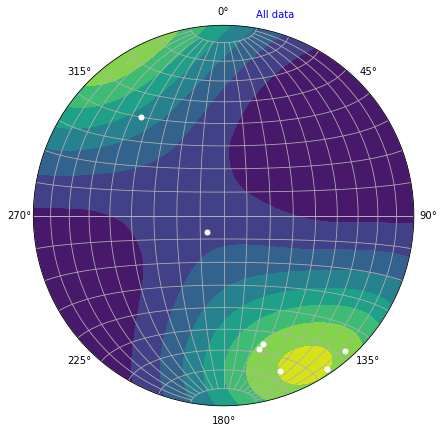

----------------------------------------------------------------------------------------------------------------------
Hawker Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
Callanna Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
alluvium 38485 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Bimbowrie Suite observations has no observations
----------------------------------------------------------------------------------------------------------------------
Curnamona Group observations n= 4
strike/dip of girdle 153.8519637575496 / 76.85129167712108


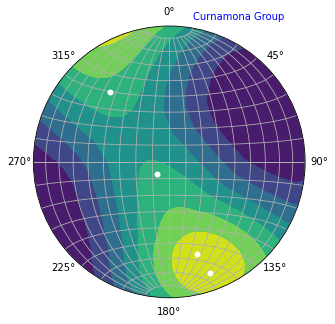

----------------------------------------------------------------------------------------------------------------------
Strathearn Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
dunes 38496 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Namba Formation observations has no observations
----------------------------------------------------------------------------------------------------------------------
Wooltana Volcanics observations has no observations
----------------------------------------------------------------------------------------------------------------------
colluvium 38491 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Eurinilla Formation observations has no o

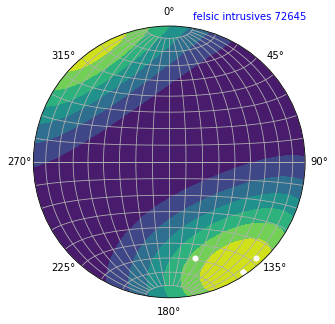

----------------------------------------------------------------------------------------------------------------------
Yudnamutana Subgroup observations has no observations
----------------------------------------------------------------------------------------------------------------------
Lake Frome Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
lake deposits 38492 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Terrapinna Granite observations has no observations
----------------------------------------------------------------------------------------------------------------------
Arrowie Formation observations has no observations
----------------------------------------------------------------------------------------------------------------------
Willawortina Formation obs

In [22]:
geology = gpd.read_file(geology_file,bbox=bbox)

geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)

orientations = gpd.read_file(structure_file,bbox=bbox)
if(len(orientations)<2):
    raise NameError('Not enough orientations to complete calculations (need at least 2)')
group_girdle=m2l_utils.plot_bedding_stereonets(orientations,geology,c_l)


## Test code to automatically create super_groups and use_group3

In [23]:
misorientation=30
super_groups,use_gcode3=m2l_topology.super_groups_and_groups(group_girdle,tmp_path,misorientation)


,plunge,bearing,num orientations
Curnamona Group,13.148708,63.851964,4
felsic intrusives 72645,39.311503,50.120249,4
Hawker Group,-999.000000,-999.000000,0
Yerelina Subgroup,-999.000000,-999.000000,0
sedimentary rocks 72357,-999.000000,-999.000000,0
Golden Pole Granite,-999.000000,-999.000000,0
Radium Creek Metamorphics,-999.000000,-999.000000,0
felsic intrusives 72695,-999.000000,-999.000000,0
Crocker Well Suite,-999.000000,-999.000000,0
Pooraka Formation,-999.000000,-999.000000,0


## Decide on super groups and groups
Supergroups define what shall be interpolated as single system   
use_gcode defines which groups we choose to calculate model from  

<font color='red'>The following outputs are the default settings that put all groups as one super_group for orientation interpolation purposes and use_gcode3 defines which groups will actually be modelled If after looking at the stereonets you want to change these defaults, just copy paste the two following lines into the next cell below and edit them as you wish. </font>  

In [24]:

print("super_groups=",super_groups)
print("use_gcode3=",use_gcode3)


super_groups= [['Hawker Group'], ['Curnamona Group', 'felsic intrusives 72645'], ['Yerelina Subgroup', 'sedimentary rocks 72357', 'Golden Pole Granite', 'Radium Creek Metamorphics', 'felsic intrusives 72695', 'Crocker Well Suite', 'Pooraka Formation', 'Mount Neill Granite', 'British Empire Granite', 'Telford Gravel', 'Parabarana Sandstone', 'Umberatana Group', 'Moolawatana Suite', 'Saltbush Subgroup', 'Pound Subgroup', 'Pepegoona Porphyry', 'Freeling Heights Quartzite@ Mount Adams Quartzite@ Yagdlin Phyllite', 'Nooldoonooldoona Trondhjemite', 'Box Bore Granite', 'Warragee Member', 'Wattleowie Granite', 'Burra Group', 'Radium Ridge Breccia@ Mount Gee Sinter', 'Callanna Group', 'Basso Suite', 'alluvium 38485', 'Bimbowrie Suite', 'Strathearn Group', 'dunes 38496', 'Namba Formation', 'Wooltana Volcanics', 'colluvium 38491', 'Eurinilla Formation', 'sand plain 38499', 'Millyera Formation', 'Wilpena Group', 'lunette dunes 72955', 'Emeroo Subgroup', 'Yudnamutana Subgroup', 'Lake Frome Group', 

## Preprocess data to ensure it meets modelling requirements

In [25]:
print('only processing',use_gcode3)

inputs=('')

if(workflow['model_engine'] =='geomodeller'):
    inputs=('invented_orientations','intrusive_orientations','fat_orientations','near_fault_orientations','fault_tip_contacts','contact_orientations')
elif(workflow['model_engine']=='loopstructural'):
    inputs=('invented_orientations','fat_orientations','contact_orientations','intrusive_orientations')
elif(workflow['model_engine']=='gempy'):
    inputs=('invented_orientations','interpolated_orientations','fat_orientations')
elif(workflow['model_engine']=='noddy'):
    inputs=('')

only processing ['Curnamona_Group', 'felsic_intrusives_72645', 'Hawker_Group', 'Yerelina_Subgroup', 'sedimentary_rocks_72357', 'Golden_Pole_Granite', 'Radium_Creek_Metamorphics', 'felsic_intrusives_72695', 'Crocker_Well_Suite', 'Pooraka_Formation', 'Mount_Neill_Granite', 'British_Empire_Granite', 'Telford_Gravel', 'Parabarana_Sandstone', 'Umberatana_Group', 'Moolawatana_Suite', 'Saltbush_Subgroup', 'Pound_Subgroup', 'Pepegoona_Porphyry', 'Freeling_Heights_Quartzite@_Mount_Adams_Quartzite@_Yagdlin_Phyllite', 'Nooldoonooldoona_Trondhjemite', 'Box_Bore_Granite', 'Warragee_Member', 'Wattleowie_Granite', 'Burra_Group', 'Radium_Ridge_Breccia@_Mount_Gee_Sinter', 'Callanna_Group', 'Basso_Suite', 'alluvium_38485', 'Bimbowrie_Suite', 'Strathearn_Group', 'dunes_38496', 'Namba_Formation', 'Wooltana_Volcanics', 'colluvium_38491', 'Eurinilla_Formation', 'sand_plain_38499', 'Millyera_Formation', 'Wilpena_Group', 'lunette_dunes_72955', 'Emeroo_Subgroup', 'Yudnamutana_Subgroup', 'Lake_Frome_Group', 'la

## Plot geology polygons and bounding box

C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\lithology_Curnamona_UTM.shp


,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,...,captdate,moddate,plotrank,featureid,geolunitid,st_area(sh,st_perimet,yngage,oldage,geometry
0,367,EOlh,EOl,8159,Hawker Group,Limestone@ siltstone@ shale; lesser sandstone@...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Tommotian to Early Cambrian,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0058037,GA.GeologicUnit.SurfaceGeology1M.8159,0.001464,0.228110,509,529,"POLYGON ((338500.080 6534596.290, 338473.900 6..."
1,427,Nsc,Ns,3338,Callanna Group,Siltstone@ locally carbonaceous; sandstone@ lo...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0058204,GA.GeologicUnit.SurfaceGeology1M.3338,0.000921,0.340800,635,720,"POLYGON ((337607.730 6661780.900, 337994.100 6..."
2,1083,Qa,Qa,38485,alluvium 38485,Channel and flood plain alluvium; gravel@ sand...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0057560,GA.GeologicUnit.SurfaceGeology1M.38485,0.011165,3.363716,0.0,0.0117,"POLYGON ((398599.684 6498514.088, 398580.933 6..."
3,1967,Mgbb,Mg,69582,Bimbowrie Suite,Monzogranite@ biotite-muscovite.,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Mesoproterozoic,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0043071,GA.GeologicUnit.SurfaceGeology1M.69582,0.000883,0.201596,1000,1600,"POLYGON ((424656.808 6461680.622, 424773.119 6..."
4,2082,Lnwc,Ln,35326,Curnamona Group,Metasediments characterised by calc-silicate m...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian,http://resource.geosciml.org/classifier/ics/is...,...,2008-07-11,2008-07-11,1,GA_GUP1M_0043848,GA.GeologicUnit.SurfaceGeology1M.35326,0.000189,0.071282,1600,1800,"POLYGON ((422956.356 6468018.144, 422924.319 6..."


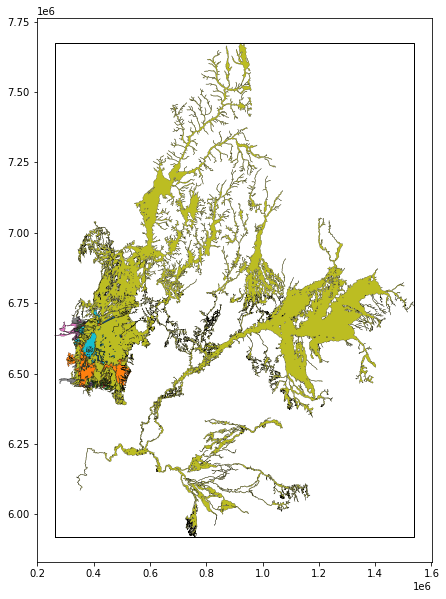

In [26]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

geology_ll[c_l['g']].fillna(geology_ll[c_l['g2']], inplace=True)
geology_ll[c_l['g']].fillna(geology_ll[c_l['c']], inplace=True)
display(geology_ll.head())
base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save geology to file as WKT

In [27]:
hint_flag=False # use GSWA strat database to provide relative age hints
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

504  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

269  points


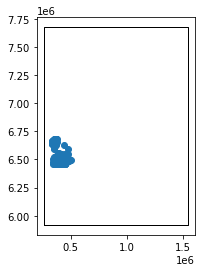

In [28]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save orientations data point data as WKT

8  points


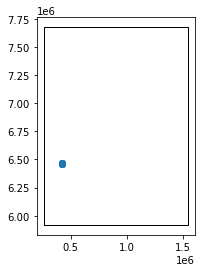

In [29]:
orientations = gpd.read_file(structure_file,bbox=bbox)

sub_pts = orientations[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

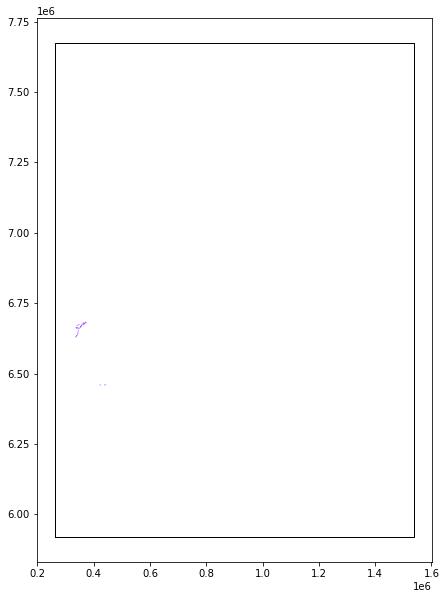

In [30]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [31]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

96  polylines


## Create map2model input file

In [46]:
print(m2m_cpp_path)
m2m_cpp_path = r'C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\m2m_cpp' + "\\"
m2m_cpp_path = r'C:\Users\rscott\OneDrive - OZ Minerals\Exploration\map2loop\m2m_cpp' + "\\"

print(m2m_cpp_path)
#m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE')
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,5000.0,'Fe,Cu,Au,NONE')


../m2m_cpp/
C:\Users\rscott\OneDrive - OZ Minerals\Exploration\map2loop\m2m_cpp\


## Calculate topology

In [47]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())
#%system map2model.exe Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"])
else:
    subprocess.run(["./map2model", "Parfile"])

C:\Users\rscott\OneDrive - OZ Minerals\Exploration\map2loop\m2m_cpp


## Simple network graph of the geology with legend

In [48]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

0    'EOlh'
1    'Nsc'
2    'Qa'
3    'Mgbb'
4    'Lnwc'
5    'Lnwr'
6    'Qd'
7    'Czcna'
8    'Nbcw'
9    'Qrc'
10    'Qteu'
11    'Czs'
12    'Qtmi'
13    'Nswl'
14    'Qdlu'
15    'Nsbe'
16    'Lg'
17    'Nsuu'
18    'EOsf'
19    'Qt'
20    'Mgmp'
21    'Qsar'
22    'Czcwi'
23    'Lgba'
24    'Cqrg'
25    'Nsu'
26    'Nsbr'
27    'Czc'
28    'Mgmg'
29    'Lnrc'
30    'Mg'
31    'Mgcr'
32    'Qrcp'
33    'Mgbn'
34    'OSgbe'
35    'Qste'
36    'Nsuy'
37    'Ksp'
38    'Mgm'
39    'Lnwab'
40    'Nswp'
41    'Mgpe'
42    'Myfy'
43    'Mgbo'
44    'Mgmb'
45    'Esfw'
46    'Mgmi'
47    'Czcey'


## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>




C:\Users\rscott\OneDrive - OZ Minerals\Exploration\map2loop\map2loop
C:\Users\rscott\OneDrive - OZ Minerals\Exploration\map2loop\map2loop


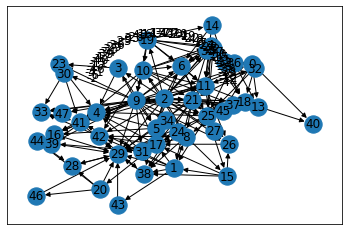

In [49]:
os.chdir('../map2loop')

print(os.getcwd())

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


## Next we define an area of interest and some other basic stuff

In [32]:
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

138.27613763774386 152.59255060752085 -36.890029291448556 -20.696662286194744


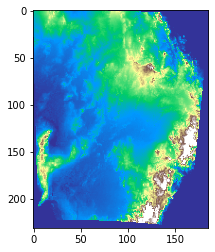

In [33]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if(((not os.path.exists(dtm_file)) or (not local_paths)) and net):    
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)

dtm = rasterio.open(dtm_reproj_file)
pyplot.imshow(dtm.read(1), cmap='terrain',vmin=0,vmax=1000)
pyplot.show()

## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

../../map2loop\map2loop\m2l_topology.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(p+1) #display strat graph for one group


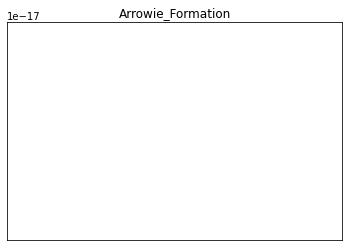

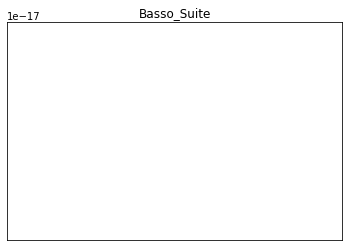

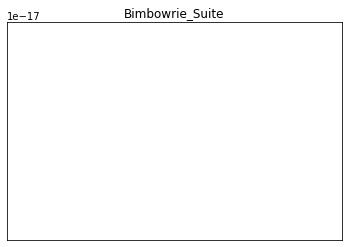

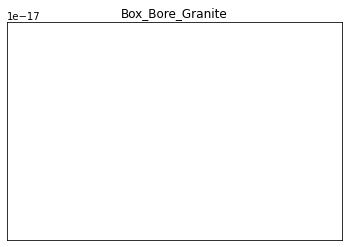

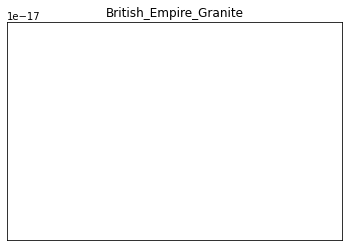

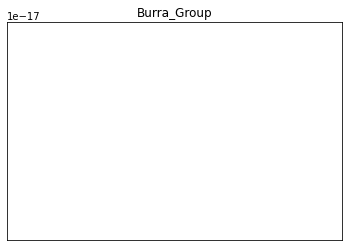

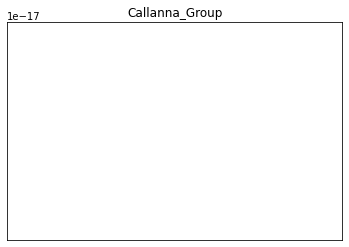

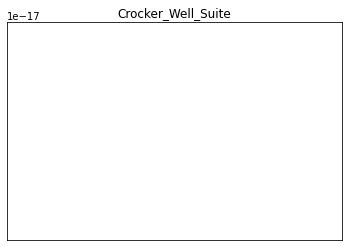

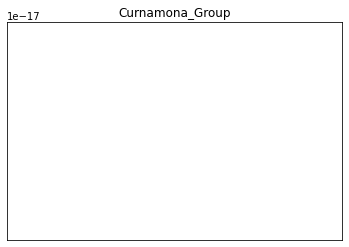

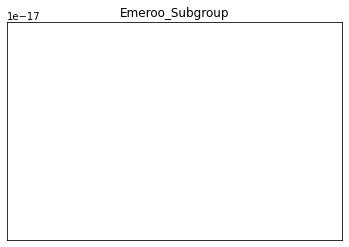

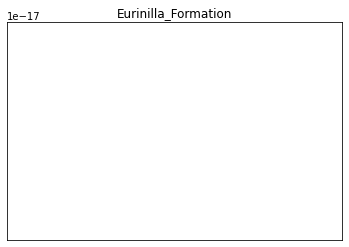

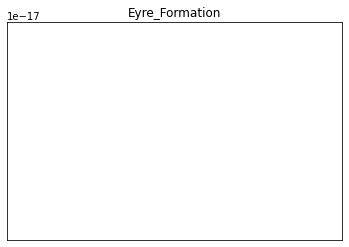

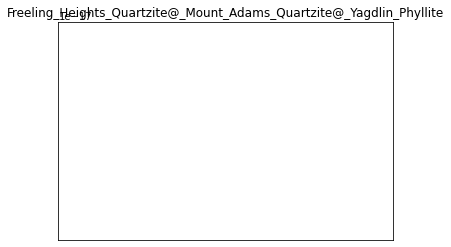

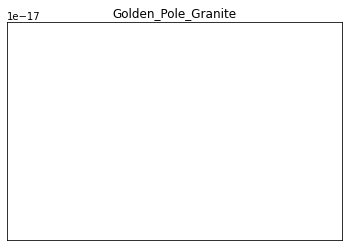

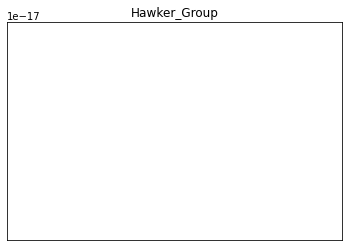

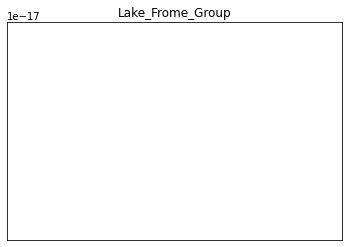

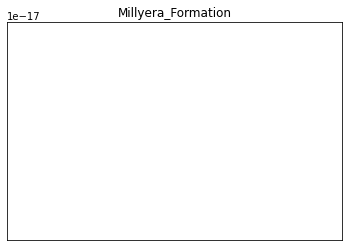

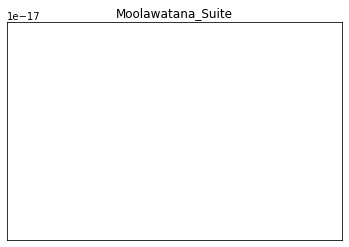

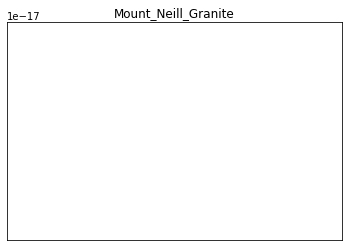

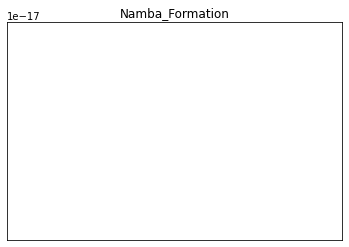

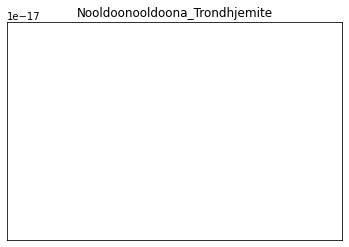

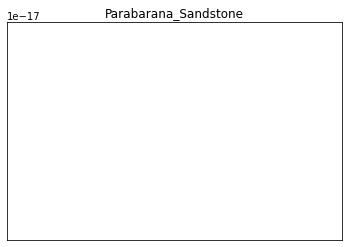

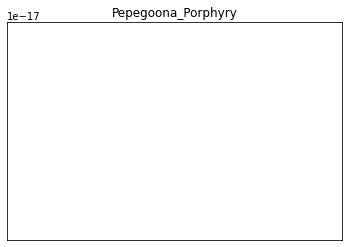

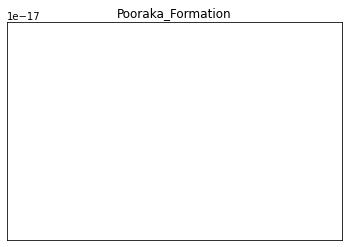

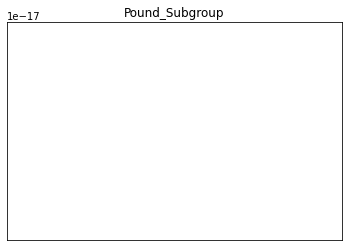

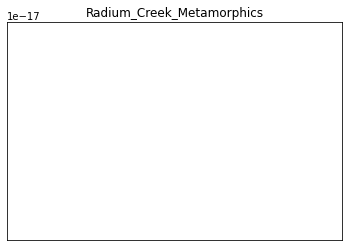

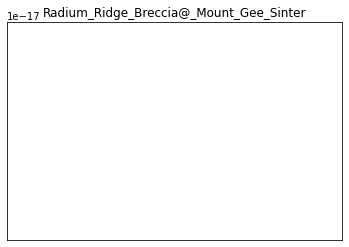

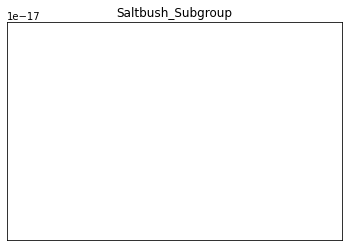

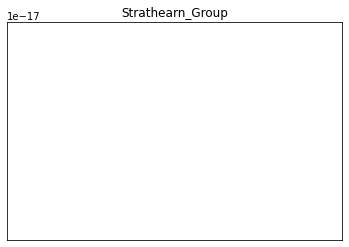

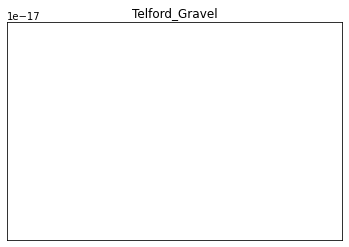

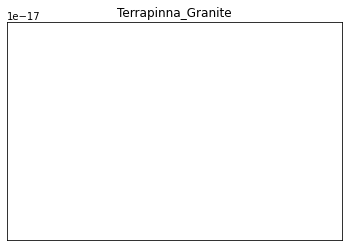

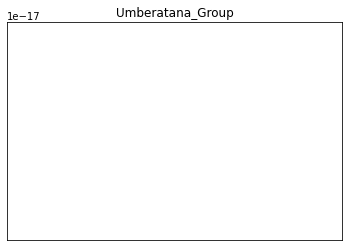

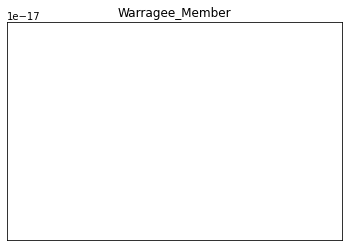

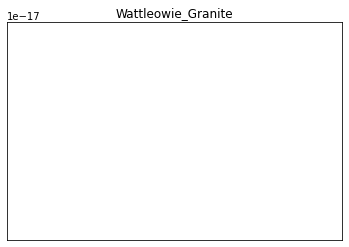

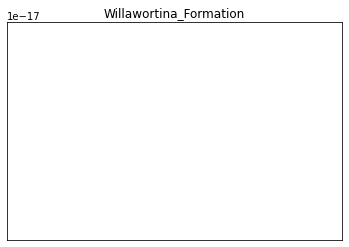

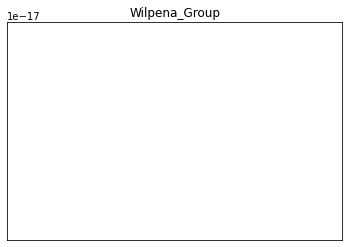

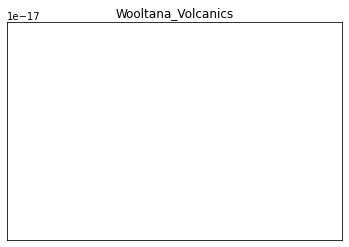

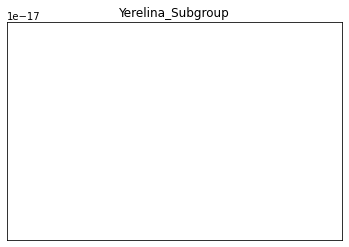

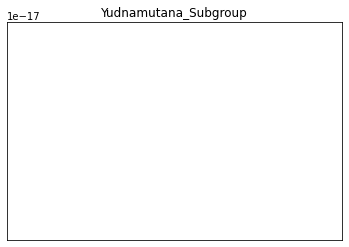

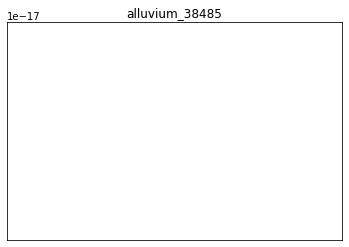

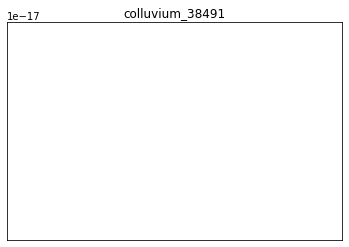

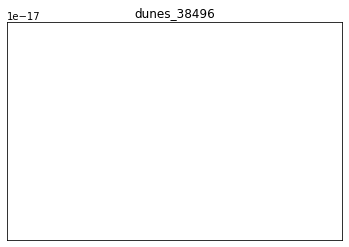

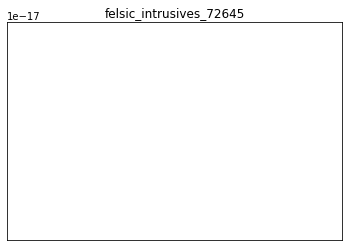

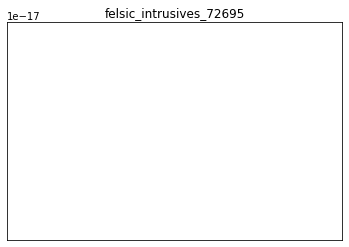

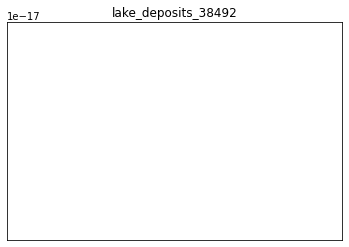

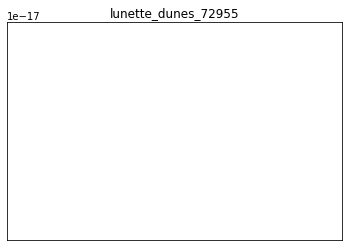

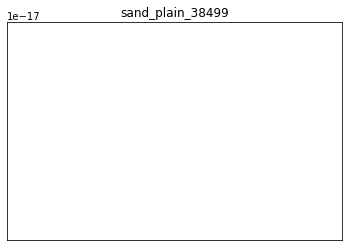

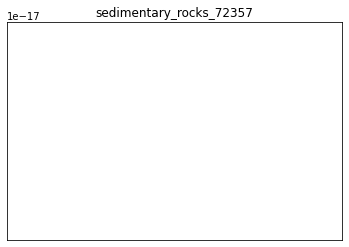

In [34]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\faults_Curnamona_UTM.shp


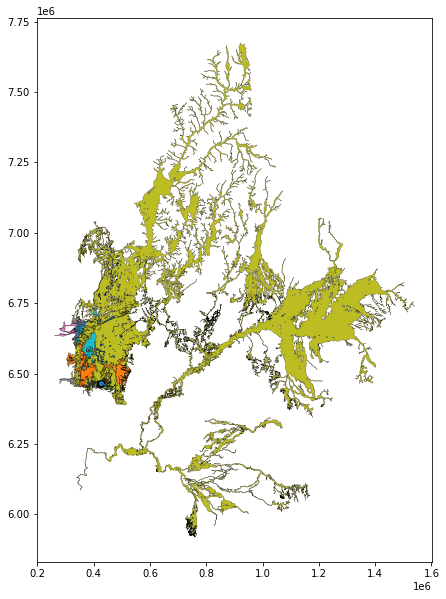

In [35]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)
geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs

sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

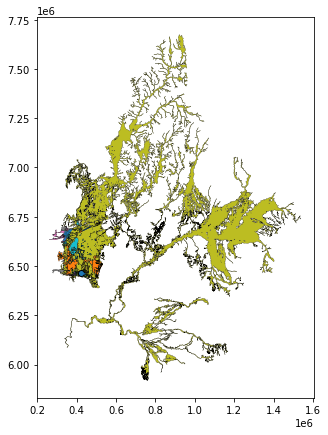

In [54]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]

if(workflow['fold_axial_traces']):
    all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
    folds_clip=m2l_utils.clip_shp(all_folds,polygo)
    if(len(folds_clip)>0):
        folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]


geol_clip=gpd.overlay(geology, polygo, how='intersection')
faults_clip=m2l_utils.clip_shp(all_faults,polygo)

structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['f'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')


if(c_l['dd']=='strike'):
    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
    c_l['dd']='azimuth2'
    
geol_clip.to_file(tmp_path+'geol_clip.shp')

structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,min,max,ave
group_,,,,
alluvium_38485,0,0.0000,0.0117,0.00585
Pooraka_Formation,1,0.0117,0.1260,0.06885
colluvium_38491,2,0.0000,2.5800,1.29000
lunette_dunes_72955,3,0.0000,2.5800,1.29000
lake_deposits_38492,4,0.0000,2.5800,1.29000
Eurinilla_Formation,5,0.0117,2.5800,1.29585
Millyera_Formation,6,0.0117,2.5800,1.29585
Arrowie_Formation,7,0.0117,2.5800,1.29585
Telford_Gravel,8,0.0117,2.5800,1.29585


[]

{-44: 'Arrowie_Formation',
 -12: 'Basso_Suite',
 -18: 'Bimbowrie_Suite',
 -23: 'Box_Bore_Granite',
 -38: 'British_Empire_Granite',
 -31: 'Burra_Group',
 -32: 'Callanna_Group',
 -21: 'Crocker_Well_Suite',
 -15: 'Curnamona_Group',
 -30: 'Emeroo_Subgroup',
 -47: 'Eurinilla_Formation',
 -3: 'Eyre_Formation',
 -28: 'Freeling_Heights_Quartzite@_Mount_Adams_Quartzite@_Yagdlin_Phyllite',
 -24: 'Golden_Pole_Granite',
 -7: 'Hawker_Group',
 -8: 'Lake_Frome_Group',
 -48: 'Millyera_Formation',
 -22: 'Moolawatana_Suite',
 -19: 'Mount_Neill_Granite',
 -4: 'Namba_Formation',
 -20: 'Nooldoonooldoona_Trondhjemite',
 -10: 'Parabarana_Sandstone',
 -27: 'Pepegoona_Porphyry',
 -43: 'Pooraka_Formation',
 -37: 'Pound_Subgroup',
 -13: 'Radium_Creek_Metamorphics',
 -1: 'Radium_Ridge_Breccia@_Mount_Gee_Sinter',
 -14: 'Saltbush_Subgroup',
 -16: 'Strathearn_Group',
 -45: 'Telford_Gravel',
 -26: 'Terrapinna_Granite',
 -33: 'Umberatana_Group',
 -9: 'Warragee_Member',
 -25: 'Wattleowie_Granite',
 -5: 'Willawortina_Fo

group choices: 1 (more than 10 groups)


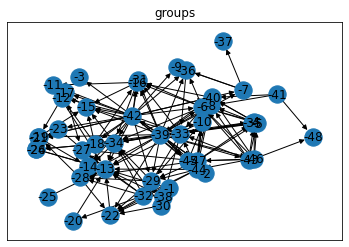

In [55]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Calculate cover depth grid and contacts    
Grid is assumed to be of depth below surface   

Also need to cater for case when we only have grid, no shapefile, so need to add a fake horizontal orientation in the middle of the map at average depth.

In [36]:
if(workflow['cover_map']):

    dtm = rasterio.open(dtm_reproj_file)
    dtb_raw = rasterio.open(dtb_grid)

    cover=gpd.read_file(cover_map_path)

    with fiona.open(cover_map_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(dtb_grid) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(dtb_clip, "w", **out_meta) as dest:
        dest.write(out_image)  

    dtb = rasterio.open(dtb_clip)
    
    m2l_geometry.process_cover(output_path,dtm,dtb,dtb_null,cover,workflow['cover_map'],cover_dip,bbox,dst_crs,spacing,contact_decimate=3,use_vector=True,use_grid=True)    
    

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up?



Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

In [59]:
c_l['bo'] = 'descr'
c_l['btype'] = 'beoi'

1 orientations saved to C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/orientations.csv


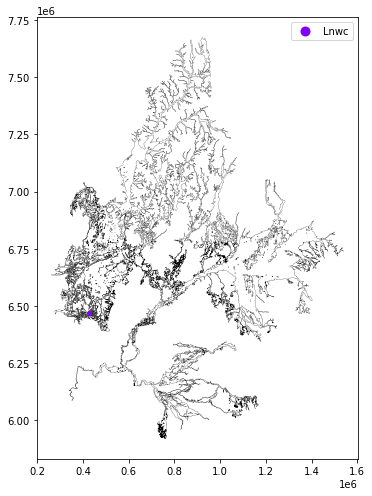

In [60]:
m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,workflow['cover_map'])

m2l_utils.plot_points(output_path+'orientations.csv',geol_clip, 'formation','X','Y',True)

## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [61]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,structure_clip,c_l)

extra orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output//empty_series_orientations.csv


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [62]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 54671 deci_pts= 7384
saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/all_contacts.csv and C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [63]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

decimated contacts saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/contacts4.csv


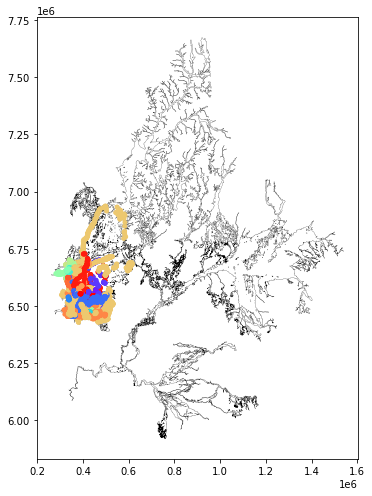

In [64]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,workflow['cover_map'],contact_decimate,c_l)

m2l_utils.plot_points(output_path+'contacts4.csv',geol_clip, 'formation','X','Y',False)


## New interpolation test
Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for populating parts of maps where little structural data is available

In [66]:
spacing = 5000

In [67]:
basal_contacts=tmp_path+'basal_contacts.shp'

orientation_interp,contact_interp,combo_interp=m2l_interpolation.interpolation_grids(geology_file,structure_file,basal_contacts,bbox,spacing,dst_crs,scheme,super_groups,c_l)


f=open(tmp_path+'interpolated_orientations.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in orientation_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_contacts.csv','w')
f.write('X,Y,l,m,angle\n')
for row in contact_interp:
    ostr='{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_combined.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in combo_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()


['Yerelina Subgroup', 'sedimentary rocks 72357', 'Golden Pole Granite', 'Radium Creek Metamorphics', 'felsic intrusives 72695', 'Crocker Well Suite', 'Pooraka Formation', 'Mount Neill Granite', 'British Empire Granite', 'Telford Gravel', 'Parabarana Sandstone', 'Umberatana Group', 'Moolawatana Suite', 'Saltbush Subgroup', 'Pound Subgroup', 'Pepegoona Porphyry', 'Freeling Heights Quartzite@ Mount Adams Quartzite@ Yagdlin Phyllite', 'Nooldoonooldoona Trondhjemite', 'Box Bore Granite', 'Warragee Member', 'Wattleowie Granite', 'Burra Group', 'Radium Ridge Breccia@ Mount Gee Sinter', 'Callanna Group', 'Basso Suite', 'alluvium 38485', 'Bimbowrie Suite', 'Strathearn Group', 'dunes 38496', 'Namba Formation', 'Wooltana Volcanics', 'colluvium 38491', 'Eurinilla Formation', 'sand plain 38499', 'Millyera Formation', 'Wilpena Group', 'lunette dunes 72955', 'Emeroo Subgroup', 'Yudnamutana Subgroup', 'Lake Frome Group', 'lake deposits 38492', 'Terrapinna Granite', 'Arrowie Formation', 'Willawortina F

../../map2loop\map2loop\m2l_interpolation.py:1475: RuntimeWarning: divide by zero encountered in true_divide
  loscaled=np.where(scale2>0, contact_interp['l']/scale2, 0)
../../map2loop\map2loop\m2l_interpolation.py:1476: RuntimeWarning: divide by zero encountered in true_divide
  moscaled=np.where(scale2>0, contact_interp['m']/scale2, 0)


256 352
interpolated dips


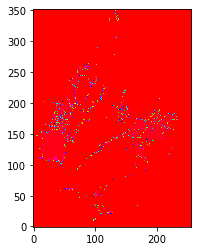

In [68]:
x=int((bbox[2]-bbox[0])/spacing)+1
y=int((bbox[3]-bbox[1])/spacing)+1
print(x,y)
dip_grid=np.ones((y,x))
dip_grid=dip_grid*-999
dip_dir_grid=np.ones((y,x))
dip_dir_grid=dip_dir_grid*-999
contact_grid=np.ones((y,x))
contact_grid=dip_dir_grid*-999
for row in combo_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    dip_grid[r,c]=float(row[5])
    dip_dir_grid[r,c]=float(row[6])

for row in contact_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    contact_grid[r,c]=float(row[4])

print('interpolated dips')
plt.imshow(dip_grid, cmap="hsv",origin='lower',vmin=-90,vmax=90)  
plt.show()

interpolated dip directions


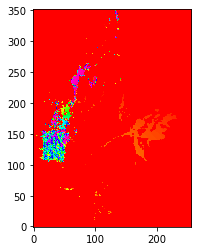

In [69]:
print('interpolated dip directions')
       
plt.imshow(dip_dir_grid, cmap="hsv",origin='lower',vmin=0,vmax=360)    
plt.show()

interpolated contacts


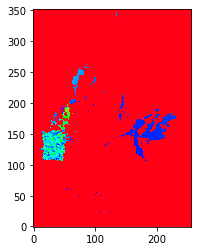

In [70]:
print('interpolated contacts')
       
plt.imshow(contact_grid, cmap="hsv",origin='lower',vmin=-360,vmax=360)    
plt.show()

## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [71]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [73]:
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2, fmod, isnan

#import importlib
#from map2loop import m2l_topology
#importlib.reload(m2l_topology)

#from map2loop import m2l_geometry
#import map2loop
#del m2l_geometry
#import sys
#sys.path.append('../../map2loop')

#print(sys.path)

#from map2loop import m2l_geometry
#del m2l_geometry
#from map2loop import m2l_geometry
#importlib.reload(m2l_geometry)
from shapely import geometry
from shapely.geometry import shape, Polygon, LineString, Point, MultiLineString, MultiPolygon

def richard_save_faults(path_faults,output_path,dtm,dtb,dtb_null,cover_map,c_l,fault_decimate,fault_min_len,fault_dip):
    #print("now in")
    faults_clip=gpd.read_file(path_faults)
    f=open(output_path+'/faults.csv',"w")
    f.write("X,Y,Z,formation\n")
    fo=open(output_path+'/fault_orientations.csv',"w")
    fo.write("X,Y,Z,DipDirection,dip,DipPolarity,formation\n")
    #fo.write("X,Y,Z,azimuth,dip,polarity,formation\n")
    fd=open(output_path+'/fault_dimensions.csv',"w")
    fd.write("Fault,HorizontalRadius,VerticalRadius,InfluenceDistance\n")
    #fd.write("Fault_ID,strike,dip_direction,down_dip\n")
    
    split=c_l['fdipest_vals'].split(",") #convert text dips to equally spaced angles
    fault_dip_choices=np.linspace(0,90, len(split)+1)
    dip_dirs={'north':(0.0,1.0),'northeast':(.707,.707),'east':(1.0,0.0),'southeast':(.707,-.707),
              'south':(0.0,-1.0),'southwest':(-.707,-.707),'west':(-1.0,0.0),'northwest':(-.707,.707)}
    
    
    for indx,flt in faults_clip.iterrows():
        if(c_l['fault'] in flt[c_l['f']]):
            fault_name='Fault_'+str(flt[c_l['o']])
            #display(flt.geometry.type)
            if(flt.geometry.type=='LineString'):
                flt_ls=LineString(flt.geometry)
                dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                strike=sqrt((dlsx*dlsx)+(dlsy*dlsy))
                if(strike>fault_min_len):
                    i=0
                    saved=0
                    for afs in flt_ls.coords:
                        if(m2l_utils.mod_safe(i,fault_decimate)==0 or i==int((len(flt_ls.coords)-1)/2) or i==len(flt_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape                         
                            if(saved==0):
                                p1x=afs[0]
                                p1y=afs[1]
                            elif(saved==1):
                                p2x=afs[0]
                                p2y=afs[1]
                            elif(saved==2):
                                p3x=afs[0]
                                p3y=afs[1]
                                # avoids narrow angles in fault traces which geomodeller refuses to solve
                                # should really split fault in two at apex, but life is too short
                                if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0): 
                                    break
                            elif(saved>2):
                                p1x=p2x
                                p1y=p2y
                                p2x=p3x
                                p2y=p3y
                                p3x=afs[0]
                                p3y=afs[1]
                                # avoids narrow angles in fault traces which geomodeller refuses to solve
                                # should really split fault in two at apex, but life is too short
                                if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0):
                                    break 
                            saved=saved+1
                            locations=[(afs[0],afs[1])]     
                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                            # slightly randomise first and last points to avoid awkward quadruple junctions etc.
                            #if(i==0 or i==len(flt_ls.coords)-1):
                            #    ostr=str(afs[0]+np.random.ranf())+","+str(afs[1]+np.random.ranf())+","+str(height)+","+fault_name+"\n"
                            #else:
                            ostr="{},{},{},{}\n"\
                                 .format(afs[0],afs[1],height,fault_name)
                            #ostr=str(afs[0])+","+str(afs[1])+","+str(height)+","+fault_name+"\n"                            
                            f.write(ostr)                
                        i=i+1  
                    if(dlsx==0.0 or dlsy == 0.0):
                        continue
                    lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                    lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))        
                    azimuth=degrees(atan2(lsy,-lsx)) % 180 #normal to line segment           
                    locations=[(flt_ls.coords[int((len(afs)-1)/2)][0],flt_ls.coords[int((len(afs)-1)/2)][1])]     
                    height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                    
                    if(flt[c_l['o']]=='-1'):
                        print(flt[c_l['o']],c_l['fdip'],flt[c_l['fdip']],c_l['fdipnull'],c_l['fdipest'],
                          flt[c_l['fdipest']],c_l['fdipest_vals'])
                    
                    if(flt[c_l['fdip']]==c_l['fdipnull']): # null specifc dip defined
                        if(not str(flt[c_l['fdipest']])=='None'): #  dip estimate defined
                            i=0
                            for choice in split:
                                if(flt[c_l['o']]=='-1'):
                                    print(choice)
                                if(choice == flt[c_l['fdipest']]):
                                    fault_dip=int(fault_dip_choices[i+1])
                                    if(flt[c_l['o']]=='-1'):
                                        print('found_dip',fault_dip)
                                i=i+1
                        else:
                            if(fault_dip == -999): # random flag
                                fault_dip=random.randint(60,90)
                    else:
                        print( flt[c_l['fdip']])
                        if flt[c_l['fdip']] == "None" or flt[c_l['fdip']] is None:
                            fault_dip = 90
                        else:
                            fault_dip=int(flt[c_l['fdip']]) # specific dip defined
                    
                    if(c_l['fdipdir_flag']=='num'): # numeric dip direction defined
                        azimuth=flt[c_l['fdipdir']]
                    elif(not str(flt[c_l['fdipdir']])=='None'): # alpha dip direction defined
                        dotprod=degrees(acos((-lsx*dip_dirs[flt[c_l['fdipdir']]][0])+(lsy*dip_dirs[flt[c_l['fdipdir']]][1])))
                        if(dotprod>45):
                            fault_dip=-fault_dip

                        
                    ostr="{},{},{},{},{},{},{}\n"\
                         .format(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0],flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1],
                                 height,azimuth,fault_dip,1,fault_name)
                    #ostr=str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0])+","+str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1])+","+height+","+str(azimuth)+","+str(fault_dip)+",1,"+fault_name+"\n"
                    fo.write(ostr)
                    strike=strike*1.25
                    ostr="{},{},{},{}\n"\
                         .format(fault_name,strike/2,strike,strike/4.0)
                    #ostr=fault_name+","+str(strike/2)+","+str(strike)+","+str(strike/4.0)+"\n"
                    fd.write(ostr)
            elif(flt.geometry.type=='MultiLineString' or flt.geometry.type=='GeometryCollection' ): #shouldn't happen any more
                sum_strike=0
                first=True
                for pline in flt.geometry:
                    flt_ls=LineString(pline)
                    dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                    dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                    sum_strike=sum_strike+sqrt((dlsx*dlsx)+(dlsy*dlsy))  
                    if(first):
                        firstx=flt_ls.coords[0][0]
                        firsty=flt_ls.coords[0][1]
                    lastx=flt_ls.coords[0][0]
                    lasty=flt_ls.coords[0][1]
                ostr="{},{},{},{}\n"\
                         .format(fault_name,sum_strike/2,sum_strike,sum_strike/4.0)    
                #ostr=fault_name+","+str(sum_strike/2)+","+str(sum_strike)+","+str(sum_strike/4.0)+"\n"
                fd.write(ostr) 
                               
                dlsx=firstx-lastx
                dlsy=firsty-lasty
                if(dlsx==0.0 or dlsy == 0.0):
                        continue            

                lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))        
                azimuth=degrees(atan2(lsy,-lsx)) % 180 #normal to line segment           
                locations=[(flt_ls.coords[int((len(afs)-1)/2)][0],flt_ls.coords[int((len(afs)-1)/2)][1])]     # should be mid-fault not mid fault segemnt but probs doesnt matter
                height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                ostr="{},{},{},{},{},{},{},\n"\
                         .format(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0],flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1],height,azimuth,fault_dip,1,fault_name)
                #ostr=str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0])+","+str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1])+","+height+","+str(azimuth)+","+str(fault_dip)+",1,"+fault_name+"\n"
                fo.write(ostr)

                for pline in flt.geometry:
                    #display(pline)
                    #display(flt)
                    flt_ls=LineString(pline)
                    dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                    dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                    if(dlsx==0.0 or dlsy == 0.0):
                        continue
                  
                    if(sum_strike>fault_min_len):
                        i=0
                        saved=0
                        for afs in flt_ls.coords:
                            if(m2l_utils.mod_safe(i,fault_decimate)==0 or i==int((len(flt_ls.coords)-1)/2) or i==len(flt_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape                         
                                if(saved==0):
                                    p1x=afs[0]
                                    p1y=afs[1]
                                elif(saved==1):
                                    p2x=afs[0]
                                    p2y=afs[1]
                                elif(saved==2):
                                    p3x=afs[0]
                                    p3y=afs[1]
                                    # avoids narrow angles in fault traces which geomodeller refuses to solve
                                    # should really split fault in two at apex, but life is too short
                                    if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0): 
                                        break
                                elif(saved>2):
                                    p1x=p2x
                                    p1y=p2y
                                    p2x=p3x
                                    p2y=p3y
                                    p3x=afs[0]
                                    p3y=afs[1]
                                    # avoids narrow angles in fault traces which geomodeller refuses to solve
                                    # should really split fault in two at apex, but life is too short
                                    if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0):
                                        break 
                                saved=saved+1
                                locations=[(afs[0],afs[1])]     
                                height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                # slightly randomise first and last points to avoid awkward quadruple junctions etc.
                                #if(i==0 or i==len(flt_ls.coords)-1):
                                #    ostr=str(afs[0]+np.random.ranf())+","+str(afs[1]+np.random.ranf())+","+str(height)+","+fault_name+"\n"
                                #else:
                                ostr="{},{},{},{}\n"\
                                     .format(afs[0],afs[1],height,fault_name)
                                #ostr=str(afs[0])+","+str(afs[1])+","+str(height)+","+fault_name+"\n"                            
                                f.write(ostr)                
                            i=i+1  


    f.close()
    fo.close()
    fd.close()
    print("fault orientations saved as",output_path+'fault_orientations.csv')
    print("fault positions saved as",output_path+'faults.csv')
    print("fault dimensions saved as",output_path+'fault_dimensions.csv')



richard_save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)


None
None
None
None
None
None
None
None
fault orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/fault_orientations.csv
fault positions saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/faults.csv
fault dimensions saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/fault_dimensions.csv


fault displacement estimates saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/fault_displacements3.csv
near-fault orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/ex_f_combo_full.csv
near-fault orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/ex_f_combo_full.csv


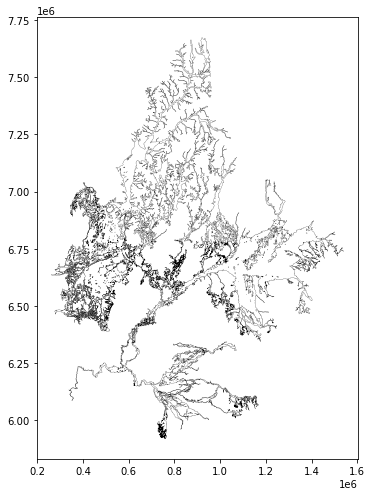

In [74]:
import warnings
warnings.filterwarnings('ignore')

faults=pd.read_csv(output_path+'faults.csv')
faults_len=len(faults)

if(faults_len>0):
    m2l_interpolation.process_fault_throw_and_near_faults_from_grid(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,bbox,
                                                                scheme,dip_grid,dip_dir_grid,x,y,spacing)

    m2l_utils.plot_points(output_path+'fault_displacements3.csv',geol_clip, 'apparent_displacement','X','Y',False)


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [75]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10

m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,workflow['cover_map'],pluton_form,pluton_dip,contact_decimate,c_l)



0 lunette_dunes_72955
1 alluvium_38485
2 Pooraka_Formation
3 sedimentary_rocks_72357
4 lake_deposits_38492
5 Millyera_Formation
6 colluvium_38491
7 Eyre_Formation
8 Box_Bore_Granite
9 Telford_Gravel
10 felsic_intrusives_72695
11 Arrowie_Formation
12 Eurinilla_Formation
13 Willawortina_Formation
14 Lake_Frome_Group
15 Parabarana_Sandstone
16 Wooltana_Volcanics
17 Namba_Formation
18 sand_plain_38499
19 dunes_38496
20 Crocker_Well_Suite
21 Saltbush_Subgroup
22 Bimbowrie_Suite
23 Strathearn_Group
24 Basso_Suite
25 Hawker_Group
26 Warragee_Member
27 Pound_Subgroup
28 Wilpena_Group
29 British_Empire_Granite
30 Yerelina_Subgroup
31 Umberatana_Group
32 Burra_Group
33 Emeroo_Subgroup
34 Callanna_Group
35 Pepegoona_Porphyry
36 Nooldoonooldoona_Trondhjemite
37 Yudnamutana_Subgroup
38 Freeling_Heights_Quartzite@_Mount_Adams_Quartzite@_Yagdlin_Phyllite
39 Mount_Neill_Granite
40 Curnamona_Group
41 felsic_intrusives_72645
42 Terrapinna_Granite
43 Golden_Pole_Granite
44 Wattleowie_Granite
45 Radium_Ri

## Extract faults and basal contacts of groups from seismic section

In [76]:
if(workflow['seismic_section']):
    seismic_line_file=data_path+'seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)
    seismic_line = gpd.read_file(seismic_line_file) #import map
    seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
    display(seismic_line)


    seismic_bbox_file=data_path+'seismic_bbox.shp'   #input geology file (if local)
    seismic_bbox = gpd.read_file(seismic_bbox_file) #import map
    seismic_bbox.set_index('POSITION',inplace=True)

    seismic_interp_file=data_path+'seismic_interp.shp'   #input geology file (if local)
    seismic_interp = gpd.read_file(seismic_interp_file) #import map
    seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
    display(seismic_interp)

    surface_cut=2000

    m2l_geometry.extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm,dtb,dtb_null,workflow['cover_map'],surface_cut)

    contacts=pd.read_csv(output_path+'contacts4.csv',",")
    seismic_contacts=pd.read_csv(output_path+'seismic_base.csv',",")
    all_contacts=pd.concat([contacts,seismic_contacts],sort=False)
    all_contacts.to_csv (output_path+'contacts4.csv', index = None, header=True)

    faults=pd.read_csv(output_path+'faults.csv',",")
    seismic_faults=pd.read_csv(output_path+'seismic_faults.csv',",")
    all_faults=pd.concat([faults,seismic_faults],sort=False)
    all_faults.to_csv (output_path+'faults.csv', index = None, header=True)


## Propagate dips along contacts


In [77]:
if(workflow['contact_dips']):
    orientations=pd.read_csv(output_path+'orientations.csv',",")
    contact_dip=-999
    contact_orientation_decimate=5
    m2l_geometry.save_basal_contacts_orientations_csv(contacts,orientations,geol_clip,tmp_path,output_path,dtm,dtb,
                            dtb_null,workflow['cover_map'],contact_orientation_decimate,c_l,contact_dip,dip_grid,spacing,bbox)

## Estimate formation thickness and normalised formation thickness

In [78]:
if(workflow['formation_thickness']):

    geology_file=tmp_path+'basal_contacts.shp'
    contact_decimate=5
    null_scheme='null'
    m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],bbox,c_l,null_scheme,contact_decimate)
    
    buffer =5000
    max_thickness_allowed=10000

    m2l_geometry.calc_thickness_with_grid(tmp_path,output_path,buffer,max_thickness_allowed,
                                          c_l,bbox,dip_grid,dip_dir_grid,x,y,spacing)
    m2l_geometry.normalise_thickness(output_path)
    
    m2l_utils.plot_points(output_path+'formation_thicknesses_norm.csv',geol_clip,'norm_th','x','y',False)


## Creates fold axial trace points

In [79]:
if(workflow['fold_axial_traces']   and len(folds_clip)>0):

    m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fold_decimate)

    #Save fold axial trace near-hinge orientations
    fat_step=750         # how much to step out normal to fold axial trace
    close_dip=-999       #dip to assign to all new orientations (-999= use local interpolated dip)

    m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,
                                                     fold_decimate,fat_step,close_dip,scheme,bbox,spacing,dip_grid,dip_dir_grid)


## Preprocess data to ensure it meets modelling requirements

In [37]:
m2l_geometry.tidy_data(output_path,tmp_path,use_gcode3,use_interpolations,use_fat,pluton_form,inputs,workflow)
dtm.close()
if(workflow['cover_map']):
    dtb.close()

No interpolated orientations available for merging.
No fat orientations available for merging.
no orientations for the group: Telford_Gravel
no orientations for the group: Wattleowie_Granite
no orientations for the group: Eurinilla_Formation
no orientations for the group: Pooraka_Formation
no orientations for the group: sedimentary_rocks_72357
no orientations for the group: Eyre_Formation
no orientations for the group: Box_Bore_Granite
no orientations for the group: lake_deposits_38492
no orientations for the group: Umberatana_Group
no orientations for the group: Saltbush_Subgroup
no orientations for the group: Emeroo_Subgroup
no orientations for the group: Millyera_Formation
no orientations for the group: Terrapinna_Granite
no orientations for the group: Nooldoonooldoona_Trondhjemite
no orientations for the group: Hawker_Group
no orientations for the group: Strathearn_Group
no orientations for the group: Pepegoona_Porphyry
no orientations for the group: Golden_Pole_Granite
no orientat

## Calculate polarity of original bedding orientation data (not used yet in final calc)

In [81]:
if(workflow['polarity']):
    m2l_geometry.save_orientations_with_polarity(output_path+'orientations.csv',output_path,c_l,tmp_path+'basal_contacts.shp',tmp_path+'all_sorts.csv',)

    m2l_utils.plot_points(output_path+'orientations_polarity.csv',geol_clip,'polarity','X','Y',True)


## Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

In [82]:
if(workflow['strat_offset']):
    m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True)
    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True)


## Analyse fault-fault topology

cycles []


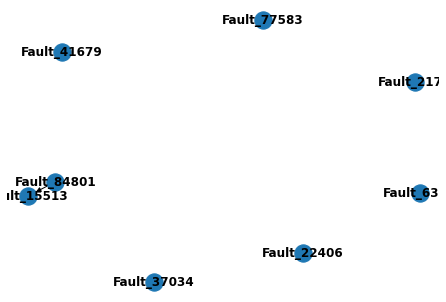

In [83]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [53]:
if(workflow['model_engine']=='geomodeller'):
    from datetime import datetime
    import shutil

    
    m2l_topology.check_near_fault_contacts(tmp_path+'faults_clip.shp',tmp_path+'all_sorts_clean.csv',
                                           output_path+'fault_dimensions.csv',output_path+'group-fault-relationships.csv',
                                           output_path+'contacts_clean.csv',c_l,dst_crs)

    nowtime=datetime.now().isoformat(timespec='minutes')   
    model_name=test_data_name+'_'+nowtime.replace(":","-").replace("T","-")
    os.mkdir(test_data_path+'/'+model_name)
    save_faults=True
    compute_etc=True
    t1 = time.time()
    m2l_export.loop2geomodeller(model_name,test_data_path,tmp_path,output_path,'../dtm/dtm_rp.tif',bbox,
                                model_top,model_base,save_faults,compute_etc,workflow)
    t2 = time.time()
    os.chdir(test_data_path+'/'+model_name)
    %system geomodellerbatch.exe -batch m2l.taskfile
    t3 = time.time()
    #%system geomodellerbatch.exe -batch m2l_compute.taskfile
    t4 = time.time()
    print("m2l",(t1-t0)/60.0,"export process",(t2-t1)/60.0,"batch process",(t3-t2)/60.0,"batch calculate",(t4-t3)/60.0,"minutes")
    #shutil.copy('../tmp','.')
    #shutil.copy('../output','.')
    #shutil.copy('../graph','.')
    #shutil.copy('../dtm','.')
    os.chdir('..')

# loopstructural test

In [54]:
if(workflow['model_engine']=='loopstructural'):
    from LoopStructural import GeologicalModel
    import lavavu
    from LoopStructural.visualisation import LavaVuModelViewer
    from LoopStructural import GeologicalModel
    f=open(tmp_path+'bbox.csv','w')
    f.write('minx,miny,maxx,maxy,lower,upper\n')
    ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
    f.write(ostr)
    f.close()
    t1 = time.time()
    fault_params = {'interpolatortype':'FDI',
                    'nelements':1e4,
                    'data_region':.1,
                    'solver':'pyamg',
    #                 overprints:overprints,
                    'cpw':10,
                    'npw':10}
    foliation_params = {'nelements':1e5,  # how many tetras/voxels
                        'buffer':0.5,  # how much to extend nterpolation around box
                        'solver':'pyamg',
                        'damp':True}
    model, m2l_data = GeologicalModel.from_map2loop_directory(test_data_path,
                                                              skip_faults=False,
                                                              fault_params=fault_params,
                                                              foliation_params=foliation_params)
    view = LavaVuModelViewer(model)
    view.nsteps = np.array([200,200,200])
    # view.add_scalar_field(model.features[0],cmap='tab20')
    view.add_model(cmap='tab20')
    view.interactive()
    t2 = time.time()
    print("m2l",(t1-t0)/60.0,"LoopStructural",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")

# gempy test

In [85]:
if(workflow['model_engine']=='gempy'):

    t1 = time.time()
    import importlib
    importlib.reload(m2l_export)


    vtk=False
    m2l_export.loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                    output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                    bbox,model_base, model_top,vtk,dtm_reproj_file)

The vertical exageration is:  145.18053310360867
Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                                                                                                                                                   values
range                                                                                                                                        2.26307e+06
$C_o$                                                                                                                                        1.21941e+11
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

ValueError: Input dimension mis-match. (input[0].shape[1] = 0, input[1].shape[1] = 5)
Apply node that caused the error: Elemwise{sub,no_inplace}(Subtensor{::, int64:int64:}.0, Subtensor{::, int64:int64:}.0)
Toposort index: 111
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(0, 0), (0, 5)]
Inputs strides: [(1277376, 8), (1277376, 8)]
Inputs values: [array([], shape=(0, 0), dtype=float64), array([], shape=(0, 5), dtype=float64)]
Inputs type_num: [12, 12]
Outputs clients: [[Elemwise{add,no_inplace}(Elemwise{sub,no_inplace}.0, TensorConstant{(1, 1) of 0.0001})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\interpolator.py", line 1027, in compile_th_fn_geo
    self.theano_graph.theano_output(),
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 558, in theano_output
    solutions[:9] = self.compute_series()
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 403, in compute_series
    series, self.updates1 = theano.scan(
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\theano\scan_module\scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 1881, in compute_a_series
    self.solve_kriging(b),
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 1188, in solve_kriging
    C_matrix = self.covariance_matrix()
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 1090, in covariance_matrix
    F_I, F_G = self.faults_matrix()
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 1063, in faults_matrix
    F_I = (self.fault_drift_at_surface_points_ref - self.fault_drift_at_surface_points_rest) + 0.0001

Debugprint of the apply node: 
Elemwise{sub,no_inplace} [id A] <TensorType(float64, matrix)> ''   
 |Subtensor{::, int64:int64:} [id B] <TensorType(float64, matrix)> ''   
 | |Elemwise{mul,no_inplace} [id C] <TensorType(float64, matrix)> ''   
 | | |AdvancedSubtensor [id D] <TensorType(float64, matrix)> ''   
 | | | |<TensorType(float64, 3D)> [id E] <TensorType(float64, 3D)>
 | | | |Subtensor{int64} [id F] <TensorType(int64, vector)> ''   
 | | | | |Nonzero [id G] <TensorType(int64, matrix)> ''   
 | | | | | |Elemwise{Cast{int8}} [id H] <TensorType(int8, vector)> ''   
 | | | | |   |Subtensor{::, int8} [id I] <TensorType(int32, vector)> ''   
 | | | | |     |fault relation matrix_copy [id J] <TensorType(int32, matrix)>
 | | | | |     |ScalarFromTensor [id K] <int8> ''   
 | | | | |       |Elemwise{Cast{int8}} [id L] <TensorType(int8, scalar)> ''   
 | | | | |         |<TensorType(int32, scalar)> [id M] <TensorType(int32, scalar)>
 | | | | |Constant{0} [id N] <int64>
 | | | |TensorConstant{0} [id O] <TensorType(int64, scalar)>
 | | | |MakeSlice [id P] <slice> ''   
 | | |   |TensorConstant{0} [id Q] <TensorType(int8, scalar)>
 | | |   |Elemwise{add,no_inplace} [id R] <TensorType(int64, scalar)> ''   
 | | |   | |Elemwise{add,no_inplace} [id S] <TensorType(int64, scalar)> ''   
 | | |   | | |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id U] <TensorType(int64, vector)> ''   
 | | |   | | | | |Coordinates of the grid points to interpolate_copy [id V] <TensorType(float64, matrix)>
 | | |   | | | |Constant{0} [id N] <int64>
 | | |   | | |Elemwise{mul,no_inplace} [id W] <TensorType(int64, scalar)> ''   
 | | |   | |   |TensorConstant{2} [id X] <TensorType(int8, scalar)>
 | | |   | |   |Elemwise{sub,no_inplace} [id Y] <TensorType(int64, scalar)> ''   
 | | |   | |     |Subtensor{int64} [id Z] <TensorType(int64, scalar)> ''   
 | | |   | |     | |Shape [id BA] <TensorType(int64, vector)> ''   
 | | |   | |     | | |All the surface_points points at once_copy [id BB] <TensorType(float64, matrix)>
 | | |   | |     | |Constant{0} [id N] <int64>
 | | |   | |     |Subtensor{int64} [id BC] <TensorType(int64, scalar)> ''   
 | | |   | |       |Shape [id BD] <TensorType(int64, vector)> ''   
 | | |   | |       | |Number of points per surface used to split rest-ref_copy [id BE] <TensorType(int32, vector)>
 | | |   | |       |Constant{0} [id N] <int64>
 | | |   | |TensorConstant{0} [id Q] <TensorType(int8, scalar)>
 | | |   |NoneConst [id BF] <NoneTypeT>
 | | |InplaceDimShuffle{x,x} [id BG] <TensorType(float64, (True, True))> ''   
 | |   |<TensorType(float64, scalar)> [id BH] <TensorType(float64, scalar)>
 | |ScalarFromTensor [id BI] <int64> ''   
 | | |Elemwise{add,no_inplace} [id BJ] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{add,no_inplace} [id BK] <TensorType(int64, scalar)> ''   
 | |   | |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
 | |   | |Elemwise{sub,no_inplace} [id Y] <TensorType(int64, scalar)> ''   
 | |   |Length of surface_points in every series[t] [id BL] <TensorType(int32, scalar)>
 | |ScalarFromTensor [id BM] <int64> ''   
 |   |Elemwise{add,no_inplace} [id BN] <TensorType(int64, scalar)> ''   
 |     |Elemwise{add,no_inplace} [id BK] <TensorType(int64, scalar)> ''   
 |     |Length of surface_points in every series[t+1] [id BO] <TensorType(int32, scalar)>
 |Subtensor{::, int64:int64:} [id BP] <TensorType(float64, matrix)> ''   
   |Elemwise{mul,no_inplace} [id C] <TensorType(float64, matrix)> ''   
   |ScalarFromTensor [id BQ] <int64> ''   
   | |Elemwise{add,no_inplace} [id BR] <TensorType(int64, scalar)> ''   
   |   |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
   |   |Length of surface_points in every series[t] [id BL] <TensorType(int32, scalar)>
   |ScalarFromTensor [id BS] <int64> ''   
     |Elemwise{add,no_inplace} [id BT] <TensorType(int64, scalar)> ''   
       |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
       |Length of surface_points in every series[t+1] [id BO] <TensorType(int32, scalar)>

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: for{cpu,Looping}(Elemwise{minimum,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, Number of points per surface used to split rest-ref, fault relation matrix, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, Range, Covariance at 0, <TensorType(float64, scalar)>, Nugget effect of gradients, Nugget effect of scalar, Attenuation factor, Sigmoid Outside, Sigmoid slope, <TensorType(int32, vector)>, <TensorType(bool, vector)>, <TensorType(int32, vector)>, Coordinates of the grid points to interpolate, All the surface_points points at once, Position of the dips, Angle of every dip, Azimuth, Polarity, Values that the blocks are taking)
Toposort index: 157
Inputs types: [TensorType(int64, scalar), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(float64, 4D), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(bool, 3D), TensorType(bool, 3D), TensorType(float64, 4D), TensorType(int64, vector), TensorType(int32, vector), TensorType(int32, matrix), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(int32, vector), TensorType(bool, vector), TensorType(int32, vector), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix)]
Inputs shapes: [(), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (2, 1, 1, 159672), (2, 11), (2, 1, 159672), (2, 1, 1), (2, 1, 159672), (2, 1, 159672), (2, 1, 1, 159672), (2,), (43,), (1, 1), (), (), (), (), (), (3,), (8565,), (), (), (), (1,), (1,), (1,), (159662, 3), (8565, 3), (1, 3), (1,), (1,), (1,), (1, 2)]
Inputs strides: [(), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (1,), (1,), (1,), (4,), (4,), (4,), (4,), (1277376, 1277376, 1277376, 8), (88, 8), (1277376, 1277376, 8), (8, 8, 8), (159672, 159672, 1), (159672, 159672, 1), (1277376, 1277376, 1277376, 8), (8,), (4,), (4, 4), (), (), (), (), (), (8,), (8,), (), (), (), (4,), (1,), (4,), (24, 8), (8, 68520), (24, 8), (8,), (8,), (8,), (16, 8)]
Inputs values: [array(1, dtype=int64), array([0]), array([5]), array([0]), array([1]), array([0]), array([11]), array([0]), array([1]), array([3]), array([ True]), array([ True]), array([ True]), array([0]), array([0]), array([0]), array([0]), 'not shown', 'not shown', 'not shown', array([[[0.0e+000]],

       [[5.4e-323]]]), 'not shown', 'not shown', 'not shown', array([ 0, 11], dtype=int64), 'not shown', array([[0]]), array(10.), array(2.), array(2.22606127), array(119946.27223883), array(4.), array([0.01, 0.01, 0.01]), 'not shown', array(2.), array(50.), array(50000.), array([0]), array([False]), array([0]), 'not shown', 'not shown', array([[0.47612219, 0.28812133, 0.44254162]]), array([60.]), array([343.]), array([1.]), array([[37., 44.]])]
Inputs type_num: [9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 7, 7, 7, 7, 12, 12, 12, 12, 0, 0, 12, 9, 7, 7, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 7, 0, 7, 12, 12, 12, 12, 12, 12, 12]
Outputs clients: [[Subtensor{int64::}(for{cpu,Looping}.0, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.1, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.2, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.3, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.4, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.5, Constant{1})], [], []]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-85-0c4b24615bdd>", line 9, in <module>
    m2l_export.loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
  File "../../map2loop\map2loop\m2l_export.py", line 1051, in loop2gempy
    gp.set_interpolator(geo_model, theano_optimizer='fast_run', dtype='float64')
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\api_modules\setters.py", line 108, in set_interpolator
    geo_model._interpolator.compile_th_fn_geo(inplace=True, grid=grid)
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\interpolator.py", line 1027, in compile_th_fn_geo
    self.theano_graph.theano_output(),
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 558, in theano_output
    solutions[:9] = self.compute_series()
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 403, in compute_series
    series, self.updates1 = theano.scan(

Debugprint of the apply node: 
for{cpu,Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Elemwise{minimum,no_inplace} [id C] <TensorType(int64, scalar)> ''   
 | | |Elemwise{minimum,no_inplace} [id D] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id E] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | | | | |Elemwise{minimum,no_inplace} [id G] <TensorType(int64, scalar)> ''   
 | | | | | | |Elemwise{minimum,no_inplace} [id H] <TensorType(int64, scalar)> ''   
 | | | | | | | |Elemwise{minimum,no_inplace} [id I] <TensorType(int64, scalar)> ''   
 | | | | | | | | |Elemwise{minimum,no_inplace} [id J] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |Elemwise{minimum,no_inplace} [id K] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |Elemwise{minimum,no_inplace} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id M] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id O] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id P] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | |Subtensor{int64} [id Q] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | | |Shape [id R] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id S] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | | | | | | | | | | | | | | | | |Constant{0} [id T] <int64>
 | | | | | | | | | | | | | | | |Subtensor{int64} [id U] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |   |Shape [id V] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | |   | |Subtensor{int64::} [id W] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | | | | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | | | | |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |   |Shape [id Y] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id Z] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | | | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | | | |Subtensor{int64} [id BA] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |   |Shape [id BB] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | |   | |Subtensor{int64::} [id BC] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | | |Subtensor{int64} [id BD] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |   |Shape [id BE] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id BF] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | |Subtensor{int64} [id BG] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |   |Shape [id BH] <TensorType(int64, vector)> ''   
 | | | | | | | | | | |   | |Subtensor{int64::} [id BI] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | |Subtensor{int64} [id BJ] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |   |Shape [id BK] <TensorType(int64, vector)> ''   
 | | | | | | | | | |   | |Subtensor{int64:int64:} [id BL] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | |Subtensor{int64} [id BM] <TensorType(int64, scalar)> ''   
 | | | | | | | | |   |Shape [id BN] <TensorType(int64, vector)> ''   
 | | | | | | | | |   | |Subtensor{int64::} [id BO] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | |Subtensor{int64} [id BP] <TensorType(int64, scalar)> ''   
 | | | | | | | |   |Shape [id BQ] <TensorType(int64, vector)> ''   
 | | | | | | | |   | |Subtensor{int64::} [id BR] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | |Subtensor{int64} [id BS] <TensorType(int64, scalar)> ''   
 | | | | | | |   |Shape [id BT] <TensorType(int64, vector)> ''   
 | | | | | | |   | |Subtensor{int64::} [id BU] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | |Subtensor{int64} [id BV] <TensorType(int64, scalar)> ''   
 | | | | | |   |Shape [id BW] <TensorType(int64, vector)> ''   
 | | | | | |   | |Subtensor{int64::} [id BX] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | | | | | |   |Constant{0} [id T] <int64>
 | | | | | |Subtensor{int64} [id BY] <TensorType(int64, scalar)> ''   
 | | | | |   |Shape [id BZ] <TensorType(int64, vector)> ''   
 | | | | |   | |Subtensor{int64::} [id CA] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | | | | |   |Constant{0} [id T] <int64>
 | | | | |Subtensor{int64} [id CB] <TensorType(int64, scalar)> ''   
 | | | |   |Shape [id CC] <TensorType(int64, vector)> ''   
 | | | |   | |Subtensor{int64::} [id CD] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | | | |   |Constant{0} [id T] <int64>
 | | | |Subtensor{int64} [id CE] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id CF] <TensorType(int64, vector)> ''   
 | | |   | |Subtensor{int64::} [id CG] <TensorType(int32, vector)> ''   
 | | |   |   |<TensorType(int32, vector)> [id CH] <TensorType(int32, vector)>
 | | |   |   |Constant{0} [id T] <int64>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id CI] <TensorType(int64, scalar)> ''   
 | |   |Shape [id CJ] <TensorType(int64, vector)> ''   
 | |   | |Subtensor{int64::} [id CK] <TensorType(int32, vector)> ''   
 | |   |   |<TensorType(int32, vector)> [id CL] <TensorType(int32, vector)>
 | |   |   |Constant{0} [id T] <int64>
 | |   |Constant{0} [id T] <int64>
 | |TensorConstant{5000} [id CM] <TensorType(int64, scalar)>
 |Subtensor{:int64:} [id CN] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id S] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |   |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{:int64:} [id CP] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id W] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CQ] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id Z] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CR] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BC] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CS] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BF] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CT] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BI] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CU] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BL] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CV] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BO] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CW] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BR] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CX] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id BU] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CY] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id BX] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CZ] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id CA] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DA] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id CD] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DB] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id CG] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DC] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id CK] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DD] <TensorType(int32, vector)> ''   
 | |TensorConstant{[   0    1..4998 4999]} [id DE] <TensorType(int32, vector)>
 | |ScalarFromTensor [id CO] <int64> ''   
 |IncSubtensor{Set;:int64:} [id DF] <TensorType(float64, 4D)> ''   
 | |AllocEmpty{dtype='float64'} [id DG] <TensorType(float64, 4D)> ''   
 | | |Elemwise{add,no_inplace} [id DH] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id DI] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id DJ] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id DK] <TensorType(float64, 4D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1,2} [id DL] <TensorType(float64, (True, False, False, False))> ''   
 | | |   |     |block matrix [id DM] <TensorType(float64, 3D)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id DN] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DJ] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id DP] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DJ] <TensorType(int64, vector)> ''   
 | | | |Constant{2} [id DQ] <int64>
 | | |Subtensor{int64} [id DR] <TensorType(int64, scalar)> ''   
 | |   |Shape [id DJ] <TensorType(int64, vector)> ''   
 | |   |Constant{3} [id DS] <int64>
 | |Rebroadcast{0} [id DK] <TensorType(float64, 4D)> ''   
 | |ScalarFromTensor [id DT] <int64> ''   
 |   |Subtensor{int64} [id DI] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id DU] <TensorType(float64, matrix)> ''   
 | |AllocEmpty{dtype='float64'} [id DV] <TensorType(float64, matrix)> ''   
 | | |Elemwise{add,no_inplace} [id DW] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id DX] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id DY] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id DZ] <TensorType(float64, matrix)> ''   
 | | |   |   |InplaceDimShuffle{x,0} [id EA] <TensorType(float64, row)> ''   
 | | |   |     |Weights vector [id EB] <TensorType(float64, vector)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 | |   |Shape [id DY] <TensorType(int64, vector)> ''   
 | |   |Constant{1} [id DO] <int64>
 | |Rebroadcast{0} [id DZ] <TensorType(float64, matrix)> ''   
 | |ScalarFromTensor [id ED] <int64> ''   
 |   |Subtensor{int64} [id DX] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id EE] <TensorType(float64, 3D)> ''   
 | |AllocEmpty{dtype='float64'} [id EF] <TensorType(float64, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id EH] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id EI] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id EJ] <TensorType(float64, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id EK] <TensorType(float64, (True, False, False))> ''   
 | | |   |     |Scalar matrix [id EL] <TensorType(float64, matrix)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id EM] <TensorType(int64, scalar)> ''   
 | | | |Shape [id EI] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id EN] <TensorType(int64, scalar)> ''   
 | |   |Shape [id EI] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id DQ] <int64>
 | |Rebroadcast{0} [id EJ] <TensorType(float64, 3D)> ''   
 | |ScalarFromTensor [id EO] <int64> ''   
 |   |Subtensor{int64} [id EH] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id EP] <TensorType(float64, 3D)> ''   
 | |AllocEmpty{dtype='float64'} [id EQ] <TensorType(float64, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id ER] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id ES] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id ET] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id EU] <TensorType(float64, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id EV] <TensorType(float64, (True, False, False))> ''   
 | | |   |     |Alloc [id EW] <TensorType(float64, matrix)> ''   
 | | |   |       |TensorConstant{0.0} [id EX] <TensorType(float64, scalar)>
 | | |   |       |Subtensor{int64} [id EY] <TensorType(int64, scalar)> ''   
 | | |   |       | |Shape [id EZ] <TensorType(int64, vector)> ''   
 | | |   |       | | |<TensorType(int32, vector)> [id CH] <TensorType(int32, vector)>
 | | |   |       | |Constant{0} [id T] <int64>
 | | |   |       |Subtensor{int64} [id FA] <TensorType(int32, scalar)> ''   
 | | |   |         |List with the number of surfaces [id FB] <TensorType(int32, vector)>
 | | |   |         |Constant{-1} [id FC] <int64>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id FD] <TensorType(int64, scalar)> ''   
 | | | |Shape [id ET] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id FE] <TensorType(int64, scalar)> ''   
 | |   |Shape [id ET] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id DQ] <int64>
 | |Rebroadcast{0} [id EU] <TensorType(float64, 3D)> ''   
 | |ScalarFromTensor [id FF] <int64> ''   
 |   |Subtensor{int64} [id ES] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id FG] <TensorType(bool, 3D)> ''   
 | |AllocEmpty{dtype='bool'} [id FH] <TensorType(bool, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id FI] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id FJ] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id FK] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id FL] <TensorType(bool, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id FM] <TensorType(bool, (True, False, False))> ''   
 | | |   |     |mask matrix [id FN] <TensorType(bool, matrix)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id FO] <TensorType(int64, scalar)> ''   
 | | | |Shape [id FK] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id FP] <TensorType(int64, scalar)> ''   
 | |   |Shape [id FK] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id DQ] <int64>
 | |Rebroadcast{0} [id FL] <TensorType(bool, 3D)> ''   
 | |ScalarFromTensor [id FQ] <int64> ''   
 |   |Subtensor{int64} [id FJ] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id FR] <TensorType(bool, 3D)> ''   
 | |AllocEmpty{dtype='bool'} [id FS] <TensorType(bool, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id FT] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id FU] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id FV] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id FW] <TensorType(bool, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id FX] <TensorType(bool, (True, False, False))> ''   
 | | |   |     |Elemwise{second,no_inplace} [id FY] <TensorType(bool, matrix)> ''   
 | | |   |       |mask matrix [id FN] <TensorType(bool, matrix)>
 | | |   |       |TensorConstant{(1, 1) of False} [id FZ] <TensorType(bool, (True, True))>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id GA] <TensorType(int64, scalar)> ''   
 | | | |Shape [id FV] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id GB] <TensorType(int64, scalar)> ''   
 | |   |Shape [id FV] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id DQ] <int64>
 | |Rebroadcast{0} [id FW] <TensorType(bool, 3D)> ''   
 | |ScalarFromTensor [id GC] <int64> ''   
 |   |Subtensor{int64} [id FU] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id GD] <TensorType(float64, 4D)> ''   
 | |AllocEmpty{dtype='float64'} [id GE] <TensorType(float64, 4D)> ''   
 | | |Elemwise{add,no_inplace} [id GF] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id GG] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id GH] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id GI] <TensorType(float64, 4D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1,2} [id GJ] <TensorType(float64, (True, False, False, False))> ''   
 | | |   |     |Elemwise{second,no_inplace} [id GK] <TensorType(float64, 3D)> ''   
 | | |   |       |block matrix [id DM] <TensorType(float64, 3D)>
 | | |   |       |TensorConstant{(1, 1, 1) of 0.0} [id GL] <TensorType(float64, (True, True, True))>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id GM] <TensorType(int64, scalar)> ''   
 | | | |Shape [id GH] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id GN] <TensorType(int64, scalar)> ''   
 | | | |Shape [id GH] <TensorType(int64, vector)> ''   
 | | | |Constant{2} [id DQ] <int64>
 | | |Subtensor{int64} [id GO] <TensorType(int64, scalar)> ''   
 | |   |Shape [id GH] <TensorType(int64, vector)> ''   
 | |   |Constant{3} [id DS] <int64>
 | |Rebroadcast{0} [id GI] <TensorType(float64, 4D)> ''   
 | |ScalarFromTensor [id GP] <int64> ''   
 |   |Subtensor{int64} [id GG] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id GQ] <TensorType(int64, vector)> ''   
 | |AllocEmpty{dtype='int64'} [id GR] <TensorType(int64, vector)> ''   
 | | |Elemwise{add,no_inplace} [id GS] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{1} [id GT] <TensorType(int64, scalar)>
 | |TensorConstant{(1,) of 0} [id GU] <TensorType(int64, vector)>
 | |Constant{1} [id DO] <int64>
 |Number of points per surface used to split rest-ref [id GV] <TensorType(int32, vector)>
 |fault relation matrix [id GW] <TensorType(int32, matrix)>
 |<TensorType(float64, scalar)> [id GX] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id GY] <TensorType(float64, scalar)>
 |Range [id GZ] <TensorType(float64, scalar)>
 |Covariance at 0 [id HA] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id HB] <TensorType(float64, scalar)>
 |Nugget effect of gradients [id HC] <TensorType(float64, vector)>
 |Nugget effect of scalar [id HD] <TensorType(float64, vector)>
 |Attenuation factor [id HE] <TensorType(float64, scalar)>
 |Sigmoid Outside [id HF] <TensorType(float64, scalar)>
 |Sigmoid slope [id HG] <TensorType(float64, scalar)>
 |<TensorType(int32, vector)> [id CL] <TensorType(int32, vector)>
 |<TensorType(bool, vector)> [id HH] <TensorType(bool, vector)>
 |<TensorType(int32, vector)> [id CH] <TensorType(int32, vector)>
 |Coordinates of the grid points to interpolate [id HI] <TensorType(float64, matrix)>
 |All the surface_points points at once [id HJ] <TensorType(float64, matrix)>
 |Position of the dips [id HK] <TensorType(float64, matrix)>
 |Angle of every dip [id HL] <TensorType(float64, vector)>
 |Azimuth [id HM] <TensorType(float64, vector)>
 |Polarity [id HN] <TensorType(float64, vector)>
 |Values that the blocks are taking [id HO] <TensorType(float64, matrix)>
for{cpu,Looping}.1 [id A] <TensorType(float64, matrix)> ''   
for{cpu,Looping}.2 [id A] <TensorType(float64, 3D)> ''   
for{cpu,Looping}.3 [id A] <TensorType(float64, 3D)> ''   
for{cpu,Looping}.4 [id A] <TensorType(bool, 3D)> ''   
for{cpu,Looping}.5 [id A] <TensorType(bool, 3D)> ''   
for{cpu,Looping}.6 [id A] <TensorType(float64, 4D)> ''   
for{cpu,Looping}.7 [id A] <TensorType(int64, vector)> ''   

Inner graphs of the scan ops:

for{cpu,Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 > |block matrix[t-1] [id HQ] <TensorType(float64, 3D)> -> [id DF]
 > |if{} [id HR] <TensorType(float64, matrix)> ''   
 > | |Vector controlling if block matrix must be recomputed[t] [id HS] <TensorType(bool, scalar)> -> [id CZ]
 > | |if{} [id HT] <TensorType(float64, matrix)> ''   
 > | | |The series (fault) is finite[t] [id HU] <TensorType(int32, scalar)> -> [id DA]
 > | | |Sum{axis=[0], acc_dtype=float64} [id HV] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | | |Sum{axis=[0], acc_dtype=float64} [id HW] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | |Subtensor{int32, ::} [id HX] <TensorType(float64, matrix)> ''   
 > |   |block matrix[t-1] [id HQ] <TensorType(float64, 3D)> -> [id DF]
 > |   |ScalarFromTensor [id HY] <int32> ''   
 > |     |<TensorType(int32, scalar)> [id HZ] <TensorType(int32, scalar)> -> [id DD]
 > |ScalarFromTensor [id HY] <int32> ''   
 > |Constant{0} [id IA] <int8>
 > |ScalarFromTensor [id IB] <int64> ''   
 >   |Elemwise{add,no_inplace} [id IC] <TensorType(int64, scalar)> ''   
 >     |Elemwise{add,no_inplace} [id ID] <TensorType(int64, scalar)> ''   
 >     | |Subtensor{int64} [id IE] <TensorType(int64, scalar)> ''   
 >     | | |Shape [id IF] <TensorType(int64, vector)> ''   
 >     | | | |Coordinates of the grid points to interpolate_copy [id IG] <TensorType(float64, matrix)> -> [id HI]
 >     | | |Constant{0} [id IH] <int64>
 >     | |Elemwise{mul,no_inplace} [id II] <TensorType(int64, scalar)> ''   
 >     |   |TensorConstant{2} [id IJ] <TensorType(int8, scalar)>
 >     |   |Elemwise{sub,no_inplace} [id IK] <TensorType(int64, scalar)> ''   
 >     |     |Subtensor{int64} [id IL] <TensorType(int64, scalar)> ''   
 >     |     | |Shape [id IM] <TensorType(int64, vector)> ''   
 >     |     | | |All the surface_points points at once_copy [id IN] <TensorType(float64, matrix)> -> [id HJ]
 >     |     | |Constant{0} [id IH] <int64>
 >     |     |Subtensor{int64} [id IO] <TensorType(int64, scalar)> ''   
 >     |       |Shape [id IP] <TensorType(int64, vector)> ''   
 >     |       | |Number of points per surface used to split rest-ref_copy [id IQ] <TensorType(int32, vector)> -> [id GV]
 >     |       |Constant{0} [id IH] <int64>
 >     |TensorConstant{0} [id IR] <TensorType(int8, scalar)>
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 > |Weights vector[t-1] [id IT] <TensorType(float64, vector)> -> [id DU]
 > |if{} [id IU] <TensorType(float64, vector)> ''   
 > | |Vector controlling if weights must be recomputed[t] [id IV] <TensorType(bool, scalar)> -> [id CX]
 > | |Reshape{1} [id IW] <TensorType(float64, vector)> 'Dual Kriging parameters'   
 > | |Subtensor{int32:int32:} [id IX] <TensorType(float64, vector)> ''   
 > |   |Weights vector[t-1] [id IT] <TensorType(float64, vector)> -> [id DU]
 > |   |ScalarFromTensor [id IY] <int32> ''   
 > |   | |Length of weights in every series[t] [id IZ] <TensorType(int32, scalar)> -> [id CS]
 > |   |ScalarFromTensor [id JA] <int32> ''   
 > |     |Length of weights in every series[t+1] [id JB] <TensorType(int32, scalar)> -> [id CT]
 > |ScalarFromTensor [id IY] <int32> ''   
 > |ScalarFromTensor [id JA] <int32> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 > |Scalar matrix[t-1] [id JD] <TensorType(float64, matrix)> -> [id EE]
 > |if{} [id JE] <TensorType(float64, vector)> ''   
 > | |Vector controlling if scalar matrix must be recomputed[t] [id JF] <TensorType(bool, scalar)> -> [id CY]
 > | |Subtensor{int64} [id JG] <TensorType(float64, vector)> 'Value of the potential field at every point'   
 > | |Subtensor{int32} [id JH] <TensorType(float64, vector)> ''   
 > |   |Scalar matrix[t-1] [id JD] <TensorType(float64, matrix)> -> [id EE]
 > |   |ScalarFromTensor [id HY] <int32> ''   
 > |ScalarFromTensor [id HY] <int32> ''   
 > |Constant{0} [id IA] <int8>
 > |ScalarFromTensor [id IB] <int64> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, matrix)> [id JJ] <TensorType(float64, matrix)> -> [id EP]
 > |AdvancedSubtensor1 [id JK] <TensorType(float64, vector)> ''   
 > | |Subtensor{int64:int64:} [id JL] <TensorType(float64, vector)> ''   
 > | | |if{} [id JE] <TensorType(float64, vector)> ''   
 > | | |ScalarFromTensor [id JM] <int64> ''   
 > | | | |Elemwise{mul,no_inplace} [id JN] <TensorType(int64, scalar)> ''   
 > | | |   |TensorConstant{-2} [id JO] <TensorType(int8, scalar)>
 > | | |   |Elemwise{sub,no_inplace} [id IK] <TensorType(int64, scalar)> ''   
 > | | |ScalarFromTensor [id JP] <int64> ''   
 > | |   |Elemwise{neg,no_inplace} [id JQ] <TensorType(int64, scalar)> ''   
 > | |     |Elemwise{sub,no_inplace} [id IK] <TensorType(int64, scalar)> ''   
 > | |Subtensor{int32:int32:} [id JR] <TensorType(int32, vector)> ''   
 > |   |CumOp{None, add} [id JS] <TensorType(int32, vector)> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'   
 > |   |ScalarFromTensor [id JT] <int32> ''   
 > |   | |List with the number of surfaces[t] [id JU] <TensorType(int32, scalar)> -> [id CU]
 > |   |ScalarFromTensor [id JV] <int32> ''   
 > |     |List with the number of surfaces[t+1] [id JW] <TensorType(int32, scalar)> -> [id CV]
 > |<TensorType(int32, scalar)> [id HZ] <TensorType(int32, scalar)> -> [id DD]
 > |Elemwise{sub,no_inplace} [id JX] <TensorType(int32, vector)> ''   
 >   |Subtensor{int32:int32:} [id JY] <TensorType(int32, vector)> ''   
 >   | |TensorConstant{[   1    2..4998 4999]} [id JZ] <TensorType(int32, vector)>
 >   | |ScalarFromTensor [id JT] <int32> ''   
 >   | |ScalarFromTensor [id JV] <int32> ''   
 >   |TensorConstant{(1,) of 1} [id KA] <TensorType(int8, (True,))>
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 > |IncSubtensor{Set;int64:int32:, int8:int64:} [id KC] <TensorType(bool, matrix)> ''   
 > | |IncSubtensor{Set;int32:int32:, int8:int64:} [id KD] <TensorType(bool, matrix)> ''   
 > | | |mask matrix[t-1] [id KE] <TensorType(bool, matrix)> -> [id FG]
 > | | |if{} [id KF] <TensorType(bool, vector)> ''   
 > | | | |<TensorType(int32, scalar)> [id KG] <TensorType(int32, scalar)> -> [id DC]
 > | | | |Elemwise{gt,no_inplace} [id KH] <TensorType(bool, vector)> ''   
 > | | | | |if{} [id JE] <TensorType(float64, vector)> ''   
 > | | | | |InplaceDimShuffle{x} [id KI] <TensorType(float64, (True,))> ''   
 > | | | |   |MaxAndArgmax{axis=(0,)}.0 [id KJ] <TensorType(float64, scalar)> 'max'   
 > | | | |Subtensor{int32, int8:int64:} [id KK] <TensorType(bool, vector)> ''   
 > | | |   |mask matrix[t-1] [id KE] <TensorType(bool, matrix)> -> [id FG]
 > | | |   |ScalarFromTensor [id KL] <int32> ''   
 > | | |   | |Elemwise{sub,no_inplace} [id KM] <TensorType(int32, scalar)> ''   
 > | | |   |   |<TensorType(int32, scalar)> [id HZ] <TensorType(int32, scalar)> -> [id DD]
 > | | |   |   |TensorConstant{1} [id KN] <TensorType(int8, scalar)>
 > | | |   |Constant{0} [id IA] <int8>
 > | | |   |ScalarFromTensor [id IB] <int64> ''   
 > | | |ScalarFromTensor [id KL] <int32> ''   
 > | | |ScalarFromTensor [id HY] <int32> ''   
 > | | |Constant{0} [id IA] <int8>
 > | | |ScalarFromTensor [id IB] <int64> ''   
 > | |Subtensor{::int64} [id KO] <TensorType(bool, matrix)> ''   
 > | | |CumOp{0, mul} [id KP] <TensorType(bool, matrix)> ''   
 > | | | |Subtensor{::int64} [id KQ] <TensorType(bool, matrix)> ''   
 > | | |   |Subtensor{int64:int32:, int8:int64:} [id KR] <TensorType(bool, matrix)> ''   
 > | | |   | |IncSubtensor{Set;int32:int32:, int8:int64:} [id KD] <TensorType(bool, matrix)> ''   
 > | | |   | |ScalarFromTensor [id KS] <int64> ''   
 > | | |   | | |Elemwise{sub,no_inplace} [id KT] <TensorType(int64, scalar)> ''   
 > | | |   | |   |<TensorType(int32, scalar)> [id HZ] <TensorType(int32, scalar)> -> [id DD]
 > | | |   | |   |Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   
 > | | |   | |     |Elemwise{mul,no_inplace} [id KV] <TensorType(int64, scalar)> ''   
 > | | |   | |     | |Elemwise{add,no_inplace} [id KW] <TensorType(int64, scalar)> ''   
 > | | |   | |     | | |<TensorType(int64, scalar)> [id KX] <TensorType(int64, scalar)> -> [id GQ]
 > | | |   | |     | | |Elemwise{add,no_inplace} [id KY] <TensorType(int32, scalar)> ''   
 > | | |   | |     | |   |Subtensor{int32} [id KZ] <TensorType(int32, scalar)> ''   
 > | | |   | |     | |   | |<TensorType(int32, vector)> [id LA] <TensorType(int32, vector)> -> [id CL]
 > | | |   | |     | |   | |ScalarFromTensor [id HY] <int32> ''   
 > | | |   | |     | |   |Subtensor{int32} [id LB] <TensorType(bool, scalar)> ''   
 > | | |   | |     | |     |<TensorType(bool, vector)> [id LC] <TensorType(bool, vector)> -> [id HH]
 > | | |   | |     | |     |ScalarFromTensor [id HY] <int32> ''   
 > | | |   | |     | |Elemwise{add,no_inplace} [id KY] <TensorType(int32, scalar)> ''   
 > | | |   | |     |Subtensor{int64} [id LD] <TensorType(int32, scalar)> ''   
 > | | |   | |       |<TensorType(int32, vector)> [id LA] <TensorType(int32, vector)> -> [id CL]
 > | | |   | |       |ScalarFromTensor [id LE] <int64> ''   
 > | | |   | |         |Elemwise{sub,no_inplace} [id LF] <TensorType(int64, scalar)> ''   
 > | | |   | |           |<TensorType(int32, scalar)> [id HZ] <TensorType(int32, scalar)> -> [id DD]
 > | | |   | |           |<TensorType(int64, scalar)> [id KX] <TensorType(int64, scalar)> -> [id GQ]
 > | | |   | |ScalarFromTensor [id HY] <int32> ''   
 > | | |   | |Constant{0} [id IA] <int8>
 > | | |   | |ScalarFromTensor [id IB] <int64> ''   
 > | | |   |Constant{-1} [id LG] <int64>
 > | | |Constant{-1} [id LG] <int64>
 > | |ScalarFromTensor [id KS] <int64> ''   
 > | |ScalarFromTensor [id HY] <int32> ''   
 > | |Constant{0} [id IA] <int8>
 > | |ScalarFromTensor [id IB] <int64> ''   
 > |if{} [id LH] <TensorType(bool, vector)> ''   
 > | |<TensorType(int32, scalar)> [id LI] <TensorType(int32, scalar)> -> [id DB]
 > | |Elemwise{gt,no_inplace} [id LJ] <TensorType(bool, vector)> ''   
 > | | |if{} [id JE] <TensorType(float64, vector)> ''   
 > | | |InplaceDimShuffle{x} [id LK] <TensorType(float64, (True,))> ''   
 > | |   |Elemwise{neg,no_inplace} [id LL] <TensorType(float64, scalar)> ''   
 > | |     |MaxAndArgmax{axis=(0,)}.0 [id LM] <TensorType(float64, scalar)> 'max'   
 > | |Elemwise{mul,no_inplace} [id LN] <TensorType(bool, vector)> ''   
 > |   |InplaceDimShuffle{x} [id LO] <TensorType(bool, (True,))> ''   
 > |   | |Elemwise{invert,no_inplace} [id LP] <TensorType(bool, scalar)> ''   
 > |   |   |Subtensor{int32} [id LB] <TensorType(bool, scalar)> ''   
 > |   |Elemwise{second,no_inplace} [id LQ] <TensorType(bool, vector)> ''   
 > |     |if{} [id JE] <TensorType(float64, vector)> ''   
 > |     |TensorConstant{(1,) of True} [id LR] <TensorType(bool, (True,))>
 > |ScalarFromTensor [id HY] <int32> ''   
 > |Constant{0} [id IA] <int8>
 > |ScalarFromTensor [id IB] <int64> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 > |<TensorType(bool, matrix)> [id LT] <TensorType(bool, matrix)> -> [id FR]
 > |Elemwise{add,no_inplace} [id LU] <TensorType(bool, vector)> ''   
 > | |if{} [id LH] <TensorType(bool, vector)> ''   
 > | |if{} [id LV] <TensorType(bool, vector)> ''   
 > |   |Subtensor{int32} [id LB] <TensorType(bool, scalar)> ''   
 > |   |Elemwise{gt,no_inplace} [id LJ] <TensorType(bool, vector)> ''   
 > |   |Elemwise{second,no_inplace} [id LW] <TensorType(bool, vector)> ''   
 > |     |if{} [id JE] <TensorType(float64, vector)> ''   
 > |     |TensorConstant{(1,) of False} [id LX] <TensorType(bool, (True,))>
 > |Elemwise{mul,no_inplace} [id LY] <TensorType(bool, vector)> ''   
 > | |Subtensor{:int64:} [id LZ] <TensorType(bool, vector)> ''   
 > | | |<TensorType(bool, vector)> [id LC] <TensorType(bool, vector)> -> [id HH]
 > | | |ScalarFromTensor [id MA] <int64> ''   
 > | |   |Subtensor{int64} [id MB] <TensorType(int64, scalar)> ''   
 > | |     |Shape [id MC] <TensorType(int64, vector)> ''   
 > | |     | |<TensorType(int32, vector)> [id MD] <TensorType(int32, vector)> -> [id CH]
 > | |     |Constant{0} [id IH] <int64>
 > | |Elemwise{invert,no_inplace} [id ME] <TensorType(bool, vector)> ''   
 > |   |Elemwise{Cast{bool}} [id MF] <TensorType(bool, vector)> ''   
 > |     |Subtensor{:int64:} [id MG] <TensorType(int32, vector)> ''   
 > |       |Subtensor{::, int8} [id MH] <TensorType(int32, vector)> ''   
 > |       | |fault relation matrix_copy [id MI] <TensorType(int32, matrix)> -> [id GW]
 > |       | |ScalarFromTensor [id MJ] <int8> ''   
 > |       |   |Elemwise{Cast{int8}} [id MK] <TensorType(int8, scalar)> ''   
 > |       |     |<TensorType(int32, scalar)> [id HZ] <TensorType(int32, scalar)> -> [id DD]
 > |       |ScalarFromTensor [id MA] <int64> ''   
 > |MakeSlice [id ML] <slice> ''   
 >   |TensorConstant{0} [id IR] <TensorType(int8, scalar)>
 >   |Elemwise{add,no_inplace} [id IC] <TensorType(int64, scalar)> ''   
 >   |NoneConst [id MM] <NoneTypeT>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 > |<TensorType(float64, 3D)> [id MO] <TensorType(float64, 3D)> -> [id GD]
 > |if{} [id HR] <TensorType(float64, matrix)> ''   
 > |ScalarFromTensor [id HY] <int32> ''   
 > |Constant{0} [id IA] <int8>
 > |ScalarFromTensor [id IB] <int64> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.1 [id A] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.2 [id A] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.3 [id A] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.4 [id A] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.5 [id A] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.6 [id A] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.7 [id A] <TensorType(int64, vector)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HP] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id IS] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JC] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JI] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KB] <TensorType(bool, matrix)> ''   
 >AdvancedBooleanIncSubtensor{inplace=False,  set_instead_of_inc=True} [id LS] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MN] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id KU] <TensorType(int64, scalar)> ''   

Storage map footprint:
 - Coordinates of the grid points to interpolate, Input, Shape: (159662, 3), ElemSize: 8 Byte(s), TotalSize: 3831888 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 1, 159672), ElemSize: 8 Byte(s), TotalSize: 2554752 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 159672), ElemSize: 8 Byte(s), TotalSize: 2554752 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 1, 159672), ElemSize: 8 Byte(s), TotalSize: 2554752 Byte(s)
 - for{cpu,Looping}.0, Shape: (2, 1, 1, 159672), ElemSize: 8 Byte(s), TotalSize: 2554752 Byte(s)
 - for{cpu,Looping}.2, Shape: (2, 1, 159672), ElemSize: 8 Byte(s), TotalSize: 2554752 Byte(s)
 - for{cpu,Looping}.6, Shape: (2, 1, 1, 159672), ElemSize: 8 Byte(s), TotalSize: 2554752 Byte(s)
 - block matrix, Shared Input, Shape: (1, 1, 159672), ElemSize: 8 Byte(s), TotalSize: 1277376 Byte(s)
 - Scalar matrix, Shared Input, Shape: (1, 159672), ElemSize: 8 Byte(s), TotalSize: 1277376 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 159672), ElemSize: 1 Byte(s), TotalSize: 319344 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 159672), ElemSize: 1 Byte(s), TotalSize: 319344 Byte(s)
 - for{cpu,Looping}.4, Shape: (2, 1, 159672), ElemSize: 1 Byte(s), TotalSize: 319344 Byte(s)
 - for{cpu,Looping}.5, Shape: (2, 1, 159672), ElemSize: 1 Byte(s), TotalSize: 319344 Byte(s)
 - All the surface_points points at once, Input, Shape: (8565, 3), ElemSize: 8 Byte(s), TotalSize: 205560 Byte(s)
 - mask matrix, Shared Input, Shape: (1, 159672), ElemSize: 1 Byte(s), TotalSize: 159672 Byte(s)
 - Nugget effect of scalar, Shared Input, Shape: (8565,), ElemSize: 8 Byte(s), TotalSize: 68520 Byte(s)
 - TensorConstant{[   0    1..4998 4999]}, Shape: (5000,), ElemSize: 4 Byte(s), TotalSize: 20000 Byte(s)
 - Vector controlling if weights must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if scalar matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if block matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - The series (fault) is finite, Shared Input, Shape: (45,), ElemSize: 4 Byte(s), TotalSize: 180 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 11), ElemSize: 8 Byte(s), TotalSize: 176 Byte(s)
 - for{cpu,Looping}.1, Shape: (2, 11), ElemSize: 8 Byte(s), TotalSize: 176 Byte(s)
 - Number of points per surface used to split rest-ref, Shared Input, Shape: (43,), ElemSize: 4 Byte(s), TotalSize: 172 Byte(s)
 - Weights vector, Shared Input, Shape: (11,), ElemSize: 8 Byte(s), TotalSize: 88 Byte(s)
 - Position of the dips, Input, Shape: (1, 3), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Nugget effect of gradients, Shared Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Values that the blocks are taking, Input, Shape: (1, 2), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 1), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,Looping}.3, Shape: (2, 1, 1), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,Looping}.7, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Angle of every dip, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Azimuth, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Polarity, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Length of surface_points in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Length of foliations in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Length of weights in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - List with the number of surfaces, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Range, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Covariance at 0, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Attenuation factor, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Sigmoid Outside, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Sigmoid slope, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{5000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1, 1) of 0.0}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Grade of the universal drift, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(int32, vector)>, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(int32, vector)>, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - fault relation matrix, Shared Input, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(bool, vector)>, Shared Input, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{(1, 1) of False}, Shape: (1, 1), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Full block matrix for faults or drift. We take 2 times len points for the faultdrift., Input, Shape: (0, 159672), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 23450490.0 Byte(s) 0.022 GB
 TotalSize inputs: 6844127.0 Byte(s) 0.006 GB



In [39]:
def richard_loop2gempy(test_data_name: str, tmp_path: str, vtk_path: str, orientations_file: str,
               contacts_file: str, groups_file:str,
               bbox: tuple, model_base: float, model_top: float, vtk: bool, dtm_reproj_file:str = None,
               va=None,
               verbose: bool = False, compute: bool = True):
    """

    :param test_data_name:
    :param tmp_path:
    :param vtk_path:
    :param orientations_file:
    :param contacts_file:
    :param groups_file:
    :param bbox:
    :param model_base:
    :param model_top:
    :param vtk:
    :param dtm_reproj_file:
    :param va: vertical anisotropy. Factor by which all Z coordinates are multiplied by
    :param verbose:
    :param compute:
    :return:
    """
    import gempy as gp
    from gempy import plot
    print("this one running")

    geo_model = gp.create_model(test_data_name)

    # If depth coordinates are much smaller than XY the whole system of equations becomes very unstable. Until
    # I fix it properly in gempy this is a handcrafted hack
    if va is None:
        va = (float(bbox[0]) - float(bbox[2])) / (model_base - model_top)/2

        if va < 3:
            va = 0
        else:
            print('The vertical exageration is: ', va)

    gp.init_data(geo_model, extent=[bbox[0], bbox[2], bbox[1], bbox[3], model_base * va, model_top * va],
                 resolution=(50, 50, 50),
                 path_o=orientations_file,
                 path_i=contacts_file)

    geo_model.modify_surface_points(geo_model.surface_points.df.index, Z=geo_model.surface_points.df['Z'] * va)

    if dtm_reproj_file is not None:
    #if dtm_reproj_file is None:
        # Load reprojected topography to model

        fp = dtm_reproj_file
        geo_model.set_topography(source='gdal', filepath=fp)
        #geo_model.set_topography()
        #geo_model.set_topography(source='random')
		
        print("va", va, "fp",fp)
        print(type(geo_model.grid))
        # Rescaling topography:
        #print("tv b4", geo_model.grid.topography.shape)
        ####geo_model.grid.topography.values[:, 2] *= va
        geo_model._grid.topography.values[:, 2] *= va
        #print("va", geo_model.grid.topography.values)
        ####geo_model.grid.update_grid_values()
        ####geo_model.update_from_grid()
        geo_model._grid.update_grid_values()
        geo_model.update_from_grid()

    # Pile processing:
    print(groups_file)
    contents = np.genfromtxt(groups_file,
                             delimiter=';', dtype='U100')

    # Init dictionary Series:Surfaces
    map_series_to_surfaces = {}
    choice = 0
    for group in contents:
        # Reading surfaces groups
        #surfaces_g = np.atleast_2d(np.genfromtxt(tmp_path + group + '.csv', delimiter=',', dtype='U100'))
        print(group)
        
        surfaces_g = np.atleast_2d(np.genfromtxt(tmp_path + group + '.csv', delimiter=';', dtype='U100'))
        print(surfaces_g)

        # Check if there are several choices
        if surfaces_g.shape[1] > 1:
            surfaces_g = surfaces_g[choice]
        # Deleting the first element since it is not a surface
        surfaces_g = surfaces_g[1:]
        # Creating the mapping dictionary
        map_series_to_surfaces[group] = surfaces_g.tolist()

    if verbose is True:
        print(map_series_to_surfaces)

    # Setting pile to model
    gp.map_series_to_surfaces(geo_model, map_series_to_surfaces, remove_unused_series=False)

    if('Default series' in map_series_to_surfaces):

        #    Removing related data
        del_surfaces = geo_model.surfaces.df.groupby('series').get_group('Default series')['surface']
        geo_model.delete_surfaces(del_surfaces, remove_data=True)

        # Removing series that have not been mapped to any surface
        geo_model.delete_series('Default series')

    if compute is True:
        gp.set_interpolator(geo_model, theano_optimizer='fast_run', dtype='float64')
        gp.compute_model(geo_model)

    # Visualise Model
    p3d = gp.plot_3d(geo_model, plotter_type='background', notebook=False)

    p3d3 = gp.plot_3d(geo_model, notebook=True)
	

    # Save model as vtk
    if vtk:
        vtkexp = gp._plot.export_to_vtk(geo_model, path=vtk_path, name=test_data_name + '.vtk', voxels=False, block=None,
                              surfaces=True)

    return geo_model


this one running
The vertical exageration is:  145.18053310360867
Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']
va 145.18053310360867 fp C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\dtm/dtm_rp.tif
<class 'gempy.core.model.RestrictingWrapper'>
C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/groups_clean.csv
lunette_dunes_72955
[['Choice 0,Qdlu']]
alluvium_38485
[['Choice 0,Qa']]
Pooraka_Formation
[['Choice 0,Qrcp']]
sedimentary_rocks_72357
[['Choice 0,Czc']]
lake_deposits_38492
[['Choice 0,Qt']]
colluvium_38491
[['Choice 0,Qrc']]
Box_Bore_Granite
[['Choice 0,Mgmb']]
Telford_Gravel
[['Choice 0,Qste']]
felsic_intrusives_72695
[['Choice 0,Mg']]
Arrowie_Formation
[['Choice 0,Qsar']]
Eurinilla_Formation
[['Choice 0,Qteu']]
Willawortina_Formation
[['Choice 0,Czcwi']]
Parabarana_Sandstone
[

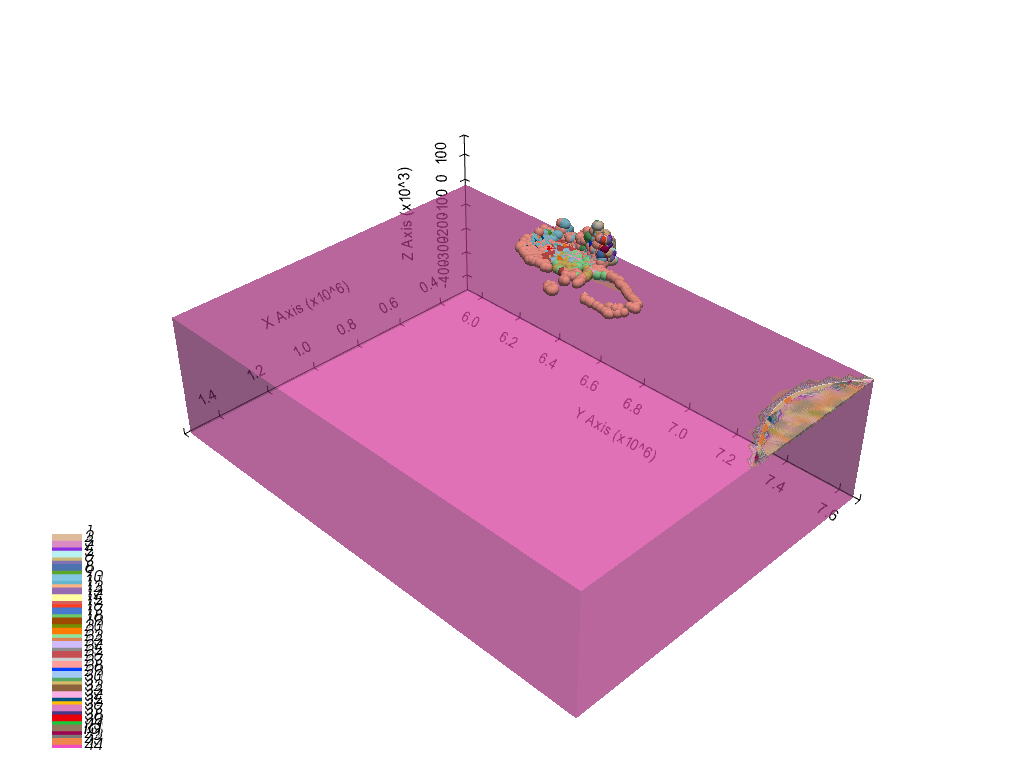

In [40]:
if(workflow['model_engine']=='gempy'):

    t1 = time.time()
    #import importlib
    #importlib.reload(m2l_export)


    vtk=False
    richardmodel = richard_loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                    output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                    bbox,model_base, model_top,vtk,dtm_reproj_file)

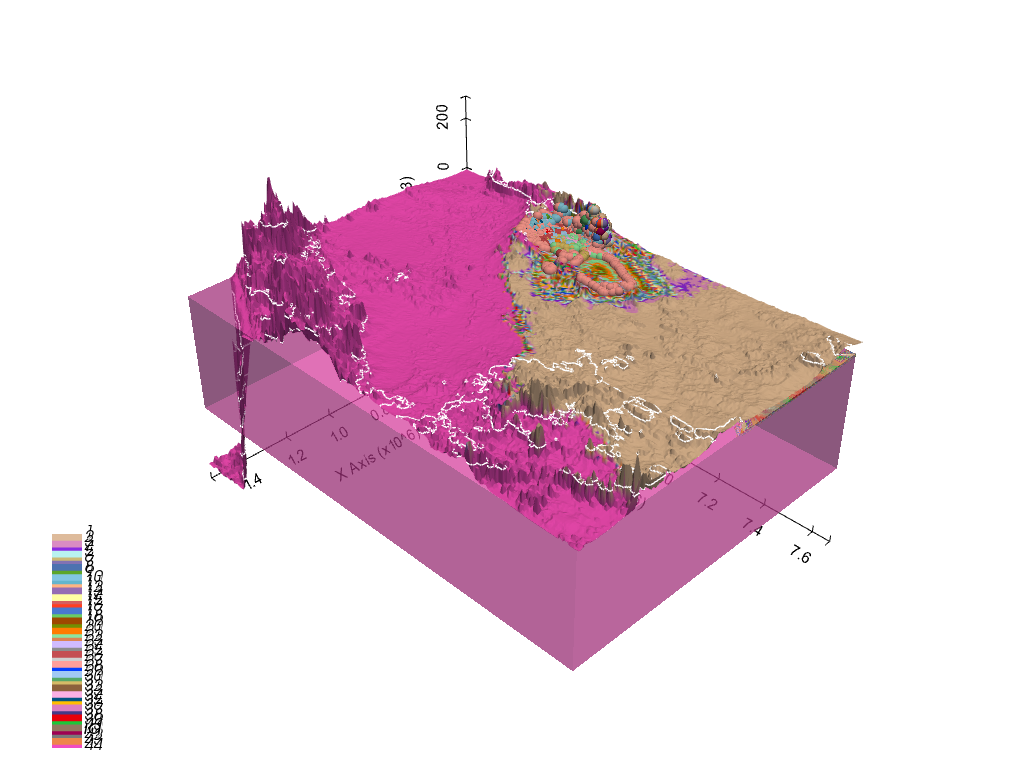

In [47]:
import gempy
richardplot = gempy.plot_3d(richardmodel, notebook=True, show_topography=True)

ValueError: Contour levels must be increasing

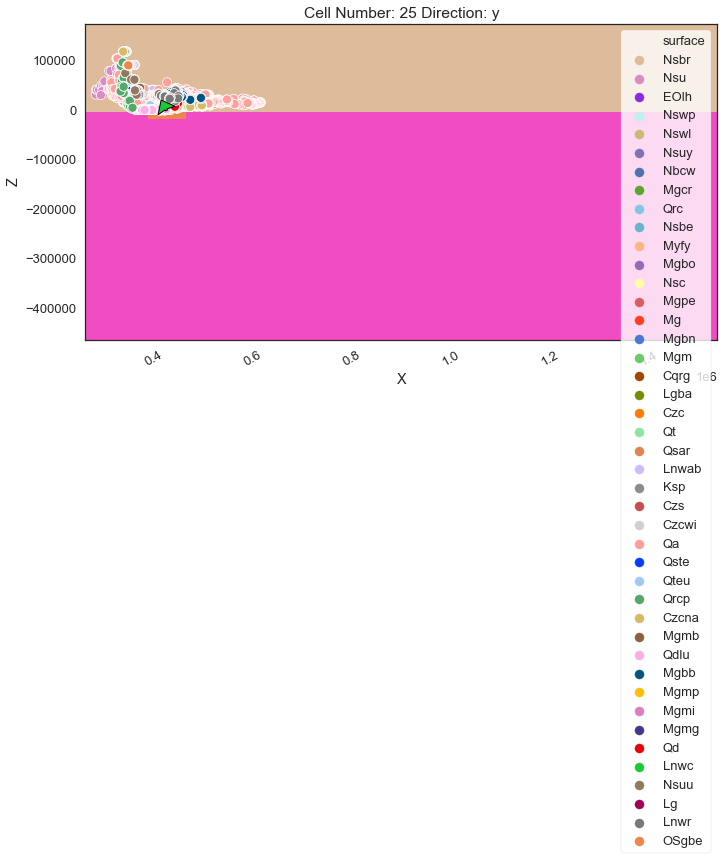

In [58]:
richardmodel.get_data()
gempy.plot_2d(richardmodel, direction='y', cell_number=25, show_data=True)

In [60]:
richardmodel.surfaces

,surface,series,order_surfaces,color,id
22,Nsbr,Default series,1,#debb9b,1
33,Nsu,Default series,2,#da8bc3,2
41,EOlh,Default series,3,#8b2be2,3
26,Nswp,Default series,4,#b9f2f0,4
35,Nswl,Default series,5,#ccb974,5
31,Nsuy,Default series,6,#8172b3,6
27,Nbcw,Default series,7,#4c72b0,7
6,Mgcr,Default series,8,#5DA629,8
16,Qrc,Default series,9,#82c6e2,9
36,Nsbe,Default series,10,#64b5cd,10


# noddy test

In [ ]:
if(workflow['model_engine']=='noddy'):

    import pynoddy.history
    import networkx as nx
    #Read a csv file with the vertices of the faults
    #see notes in the bottom of the notebook for instructions on how to generate such vertices files
    t1 = time.time()
    
    scale=1.5 #  scales mdoel to fit predefined volume (complete hack)
    
    # load fault coordinates
    faultsxy=pd.read_csv(output_path+'faults.csv')

    #load fault graph, remove cyclic loops and find (non-unique) age-ordered list 
    G=nx.read_gml(tmp_path+"fault_network.gml")
    cycles=list(nx.simple_cycles(G))
    for c in cycles:
        G.remove_edge(c[0], c[1])
    faults=nx.topological_sort(G)

    # write out Noe format format file
    file=open(tmp_path+'faults_for_noe.csv','w')
    file.write('id,DipDirecti,X,Y\n')
    for f in faults:
            fxy=faultsxy[faultsxy["formation"]==f.replace("\n","")]
            #display(f.replace("\n",""))
            for ind,xy in fxy.iterrows():
                ostr=f.replace('\n','')+',West,'+str(xy['X']/scale)+','+str(xy['Y']/scale)+'\n'
                file.write(ostr)
    file.close()
    
    csvfile = tmp_path+'faults_for_noe.csv'
    CsvFaultData = pd.read_csv(csvfile)

    #how much does the fault slip relative to the fault length
    SlipParam = 0.1

    #the xyz origin of the model you will be generating
    xy_origin=[minx/scale,miny/scale, 1200-4000]

    #Get information about each parameter in Noddy format
    #The output from the function is a dictionary with lists of the fault parameters
    noddyFormattedFaultData =  pynoddy.history.setUpFaultRepresentation(CsvFaultData,
                                                        xy_origin=xy_origin, 
                                                        SlipParam=SlipParam)

    #Create a dictionary with the stratigraphy information
    StratDict = {}
    StratDict['Heights'] = [2000, 2500, 3000, 3700]
    StratDict['Names'] = ['Intrusive', 'Felsic', 'Mafic','Sed'] 
    StratDict['Density'] =  [2.65, 2.5, 2.4, 2.3] 
    StratDict['MagSus'] = [0.0015, 0.0012, 0.0018, 0.001]

    #Now make the history file
    filename = output_path+'faultmodel.his'
    noddyFormattedFaultData =  pynoddy.history.createPyNoddyHistoryFile(noddyFormattedFaultData, StratDict, filename=filename)


In [ ]:
if(workflow['model_engine']=='noddy'):
    import vtkplotter as vtkP
    import itkwidgets
    import k3d
    import pynoddy.output
    import pynoddy.history

    modelfile = output_path+'faultmodel.his'

    # Determine the path to the noddy executable
    noddy_path = '../../pynoddy-new/noddyapp/noddy_win64.exe'

    # Where you would like to place all your output files
    outputfolder = tmp_path

    # choose what software to use for visualizing the model
    #you can also choose to change to itkwidgets, k3d, False (popup), or panel
    #you might need to install packages depending on what you choose
    vtkP.settings.embedWindow('k3d') 

    # create a plot in vtkplotter
    plot = vtkP.Plotter(axes=1, bg='white', interactive=1)

    # call the plotting function
    points = pynoddy.output.CalculatePlotStructure(modelfile, plot, noddy_path, 
                                           outputfolder=outputfolder,
                                           LithologyOpacity=0.2, outputOption=0)
    plot.show(viewup='z')
    t2 = time.time()

    print("m2l",(t1-t0)/60.0,"noddy",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")
